In [37]:
# ────────────────────────────────────────────────────────────
# Import libraries & set base paths
# ────────────────────────────────────────────────────────────
import pandas as pd
import re                       # (Not used directly below, but commonly
                                #  imported for regex work; kept for clarity)

#base_dir  = r"D:\lsy_DL\Oscilation"     # Working directory
#raw_csv   = fr"{base_dir}\0. Feature data_PIDoN4.csv"   # Source CSV file
#out_csv   = fr"{base_dir}\0. Feature data_withID.csv"  # Destination CSV file

base_dir  = r"D:\lsy_DL\Test"     # Working directory
raw_csv   = fr"{base_dir}\0. Feature data_PIDoN5.csv"   # Source CSV file
out_csv   = fr"{base_dir}\0. Feature data_withID.csv"  # Destination CSV file



df = pd.read_csv(raw_csv)       # Read source data into a DataFrame

# ────────────────────────────────────────────────────────────
# Create a new column 'waveform_id'
#    Goal: convert strings like "30 voltage waveform" → "v30"
#    Steps:
#      ① Extract numeric part with regex r"(\d+)"
#      ② Cast to integer (optional but convenient)
#      ③ Prepend the letter 'v' to obtain the final ID
# ────────────────────────────────────────────────────────────
df["waveform_id"] = (
    df["V_name"]                       # target text column
    .str.extract(r"(\d+)", expand=False)   # ① extract digits only
    .astype(int)                          # ② convert to integer
    .apply(lambda x: f"v{x}")             # ③ add 'v' prefix → "v30"
)

df = df.drop(columns=["V_name"])
df.to_csv(out_csv, index=False)
print(f"✔  waveform_id created and saved →  {out_csv}")


✔  waveform_id created and saved →  D:\lsy_DL\Test\0. Feature data_withID.csv


In [38]:
# Load the processed feature CSV and preview the first 3 rows
#csv_path = r"D:\lsy_DL\Oscilation\0. Feature data_withID.csv"
csv_path = r"D:\lsy_DL\Test\0. Feature data_withID.csv"
df = pd.read_csv(csv_path)
print(df.head(3))
print(df.shape)


      mu   sigma   rho     c    t  v1        v2        v3  v4         v5  ...  \
0  15.76  0.0474  1114  1688  118   0  3.333333  6.666667  10  13.333333  ...   
1  15.76  0.0474  1114  1688  121   0  3.666667  7.333333  11  14.666667  ...   
2  15.76  0.0474  1114  1688  122   0  4.000000  8.000000  12  16.000000  ...   

   v292  v293  v294  v295  v296  v297  v298  v299  v300  waveform_id  
0     0     0     0     0     0     0     0     0     0          v20  
1     0     0     0     0     0     0     0     0     0          v22  
2     0     0     0     0     0     0     0     0     0          v24  

[3 rows x 306 columns]
(11, 306)


In [49]:
# Load the target CSV and preview the first row (q1 … q300)
tgt_path = r"D:\lsy_DL\Test\0. Target data_PIDoN5.csv"
target_df = pd.read_csv(tgt_path)
print(target_df.head(1))
print(target_df.shape)

         q1        q2        q3        q4        q5        q6        q7  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         q8        q9       q10  ...      q291      q292      q293      q294  \
0  0.000001  0.000001  0.000001  ...  0.000001  0.000001  0.000001  0.000001   

       q295      q296      q297      q298      q299      q300  
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  

[1 rows x 300 columns]
(11, 300)


In [50]:
import pandas as pd
import torch

# ────────────────────────────────
# Load feature data
# ────────────────────────────────
#csv_path = r"D:\lsy_DL\Oscilation\0. Feature data_withID.csv"
csv_path = r"D:\lsy_DL\Test\0. Feature data_withID.csv"
df = pd.read_csv(csv_path)
print("전체 shape:", df.shape)

# ────────────────────────────────
# 1. X1 = scalar physical parameters
# ────────────────────────────────
scalar_cols = ['mu', 'sigma', 'rho', 'c', 't']
X1 = df[scalar_cols].copy()
print("X1 shape:", X1.shape)

# ────────────────────────────────
# 2. X2 = voltage waveform vectors (v1 ~ v300)
# ────────────────────────────────
vec_cols = [c for c in df.columns if c.startswith("v") and c[1:].isdigit()]
X2 = df[vec_cols].copy()
print("X2 shape:", X2.shape)

# ────────────────────────────────
# 3. waveform_id
# ────────────────────────────────
waveform_id = df[['waveform_id']].copy()
print("waveform_id shape:", waveform_id.shape)

# ────────────────────────────────
# Convert to torch tensors (optional)
# ────────────────────────────────
X1_t = torch.tensor(X1.values, dtype=torch.float32)
X2_t = torch.tensor(X2.values, dtype=torch.float32)

print("Tensor X1:", X1_t.shape)
print("Tensor X2:", X2_t.shape)


전체 shape: (11, 306)
X1 shape: (11, 5)
X2 shape: (11, 300)
waveform_id shape: (11, 1)
Tensor X1: torch.Size([11, 5])
Tensor X2: torch.Size([11, 300])


---

In [51]:
import os, re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# ============================================================
# 0) Paths
# ============================================================
#base_dir   = r"D:\lsy_DL\Oscilation"
base_dir   = r"D:\lsy_DL\Test"
feat_raw   = fr"{base_dir}\0. Feature data_withID.csv"   # (66,306)
tgt_raw    = fr"{base_dir}\0. Target data_PIDoN5.csv"   # (66,300)
feat_csv   = fr"{base_dir}\features_PIDoN.csv"          # (66,6)
lib_csv    = fr"{base_dir}\waveforms_PIDoN.csv"         # (66,301)
tgt_out    = fr"{base_dir}\targets_PIDoN_withID.csv"    # (66,301)

# ============================================================
# 1) Load raw features
# ============================================================
raw = pd.read_csv(feat_raw)
print("[info] raw shape:", raw.shape)  # (66,306)

scalar_cols = ['mu','sigma','rho','c','t']
vec_cols = sorted([c for c in raw.columns if re.fullmatch(r'v\d+', c)],
                  key=lambda s: int(s[1:]))
q_cols = [f"q{i}" for i in range(1,301)]

# ============================================================
# 2) Save features (scalars+ID) and waveforms (ID+vectors)
# ============================================================
feat = raw[scalar_cols + ['waveform_id']].copy()
feat.to_csv(feat_csv, index=False)

waves = raw[['waveform_id'] + vec_cols].copy()
waves.to_csv(lib_csv, index=False)

print("[info] features rows:", len(feat))   # should be 66
print("[info] waveforms rows:", len(waves)) # should be 66

# ============================================================
# 3) Attach waveform_id to targets (1:1, same order)
# ============================================================
tgt = pd.read_csv(tgt_raw)
if len(tgt) != len(feat):
    raise ValueError(f"targets({len(tgt)}) vs features({len(feat)}) length mismatch")

tgt_out_df = tgt.copy()
tgt_out_df.insert(0, 'waveform_id', feat['waveform_id'].values)
tgt_out_df.to_csv(tgt_out, index=False)

print("[info] targets rows:", len(tgt_out_df))  # 66

# ============================================================
# 4) Merge into final training dataframe
# ============================================================
df = feat.merge(waves, on='waveform_id').merge(tgt_out_df, on='waveform_id')
print("[info] final merged shape:", df.shape)

# ============================================================
# 5) Convert to tensors
# ============================================================
X1 = torch.tensor(df[scalar_cols].to_numpy(dtype=np.float32))   # (66,5)
X2 = torch.tensor(df[vec_cols].to_numpy(dtype=np.float32))      # (66,300)
Y  = torch.tensor(df[q_cols].to_numpy(dtype=np.float32))        # (66,300)

print("X1.shape:", X1.shape)
print("X2.shape:", X2.shape)
print("Y.shape :", Y.shape)

# ============================================================
# 6) Optional: Dataset
# ============================================================
class PIDoNDataset(Dataset):
    def __init__(self, df, scalar_cols, vec_cols, q_cols):
        self.df = df
        self.scalar_cols = scalar_cols
        self.vec_cols = vec_cols
        self.q_cols = q_cols
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x1 = row[self.scalar_cols].to_numpy(dtype=np.float32)
        x2 = row[self.vec_cols].to_numpy(dtype=np.float32)
        y  = row[self.q_cols].to_numpy(dtype=np.float32)
        wid = row['waveform_id']
        return torch.from_numpy(x1), torch.from_numpy(x2), torch.from_numpy(y), wid

dataset = PIDoNDataset(df, scalar_cols, vec_cols, q_cols)
print("[info] dataset length:", len(dataset))


[info] raw shape: (11, 306)
[info] features rows: 11
[info] waveforms rows: 11
[info] targets rows: 11
[info] final merged shape: (11, 606)
X1.shape: torch.Size([11, 5])
X2.shape: torch.Size([11, 300])
Y.shape : torch.Size([11, 300])
[info] dataset length: 11


---


In [53]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# ======================================================================
# 1) Load CSVs  ---------------------------------------------------------
# ======================================================================
base_dir  = r"D:\lsy_DL\Test"   # ★ 경로 수정
feat_csv  = fr"{base_dir}\features_PIDoN.csv"               # (66 × (5+1))
lib_csv   = fr"{base_dir}\waveforms_PIDoN.csv"              # (66 × (300+1))
tgt_csv   = fr"{base_dir}\targets_PIDoN_withID.csv"         # (66 × (300+1))

# 스칼라: 5개 고정 (p 제거)
scalar_cols = ['mu','sigma','rho','c','t']

# v1..v300: 정규식으로 안전하게 추출 후 숫자 기준 정렬
lib_cols  = pd.read_csv(lib_csv, nrows=1).columns
vec_cols  = sorted([c for c in lib_cols if re.fullmatch(r'v\d+', c)],
                   key=lambda s: int(s[1:]))

# 타깃 열
q_cols    = [f"q{i}" for i in range(1,301)]

# 데이터 로드
feat_df = pd.read_csv(feat_csv)           # columns: scalar_cols + waveform_id
waves   = pd.read_csv(lib_csv)            # columns: waveform_id + v1..v300
tgt_df  = pd.read_csv(tgt_csv)            # columns: waveform_id + q1..q300

# 방어적 재정렬(열 순서 보장)
waves = waves[['waveform_id'] + vec_cols]
missing_q = set(q_cols) - set(tgt_df.columns)
if missing_q:
    raise ValueError(f"targets file missing columns: {sorted(missing_q)}")
tgt_df = tgt_df[['waveform_id'] + q_cols]

# 병합(1:1, 66행 유지)
df = (feat_df
      .merge(waves,  on='waveform_id', how='inner')
      .merge(tgt_df, on='waveform_id', how='inner'))

# 재현성 위해 waveform_id 숫자 기준 정렬
df['_wid_num'] = df['waveform_id'].str.extract(r'(\d+)', expand=False).astype(int)
df = df.sort_values('_wid_num').drop(columns=['_wid_num'])

# 텐서 변환
X1 = torch.tensor(df[scalar_cols].to_numpy(dtype=np.float32), dtype=torch.float32)  # [N,5]
X2 = torch.tensor(df[vec_cols].to_numpy(dtype=np.float32),    dtype=torch.float32)  # [N,300]
Y  = torch.tensor(df[q_cols].to_numpy(dtype=np.float32),      dtype=torch.float32)  # [N,300]

print("X1.shape:", X1.shape)
print("X2.shape:", X2.shape)
print("Y.shape :", Y.shape)

# 300-점 파형 라이브러리(dict) : 단일 예측 시 사용
# 열 순서 의존 제거 → vec_cols 사용
waves = pd.read_csv(lib_csv)
waves = waves[['waveform_id'] + vec_cols]
WAVE_DB = dict(zip(waves['waveform_id'], waves[vec_cols].to_numpy(dtype=np.float32)))

#  GT(정답) 라이브러리 생성 (예측-실측 비교용)
GT_DB = dict(zip(tgt_df['waveform_id'], tgt_df[q_cols].to_numpy(dtype=np.float32)))
# ======================================================================
# 3) Dataset -----------------------------------------------------------
# ======================================================================
class RawSet(Dataset):
    def __init__(self, X1, X2, Y):
        self.X1, self.X2, self.Y = X1, X2, Y
    def __len__(self):  
        return len(self.Y)
    def __getitem__(self, i):
        return self.X1[i], self.X2[i], self.Y[i]

dataset = RawSet(X1, X2, Y)


X1.shape: torch.Size([11, 5])
X2.shape: torch.Size([11, 300])
Y.shape : torch.Size([11, 300])


---

[   1] mean loss 6.859e+05 | data 6.859e-01 | pde 0.000e+00 | ic 0.000e+00
[ 200] mean loss 2.053e+04 | data 2.053e-02 | pde 1.284e-03 | ic 2.751e-03
[ 400] mean loss 1.416e+04 | data 1.416e-02 | pde 3.425e-03 | ic 1.434e-02
[ 600] mean loss 1.066e+04 | data 1.066e-02 | pde 5.845e-03 | ic 2.971e-02
[ 800] mean loss 8.836e+03 | data 8.836e-03 | pde 8.493e-03 | ic 3.821e-02
[1000] mean loss 8.165e+03 | data 8.165e-03 | pde 1.042e-02 | ic 4.316e-02
[1200] mean loss 8.023e+03 | data 8.023e-03 | pde 1.121e-02 | ic 4.971e-02
[1400] mean loss 7.315e+03 | data 7.315e-03 | pde 1.219e-02 | ic 4.779e-02
[1600] mean loss 7.202e+03 | data 7.202e-03 | pde 1.338e-02 | ic 4.777e-02
[1800] mean loss 6.789e+03 | data 6.789e-03 | pde 1.267e-02 | ic 5.262e-02
[2000] mean loss 6.520e+03 | data 6.520e-03 | pde 1.304e-02 | ic 5.337e-02
[2200] mean loss 5.906e+03 | data 5.906e-03 | pde 1.356e-02 | ic 4.911e-02
[2400] mean loss 5.313e+03 | data 5.313e-03 | pde 1.388e-02 | ic 5.682e-02
[2600] mean loss 5.096e+0

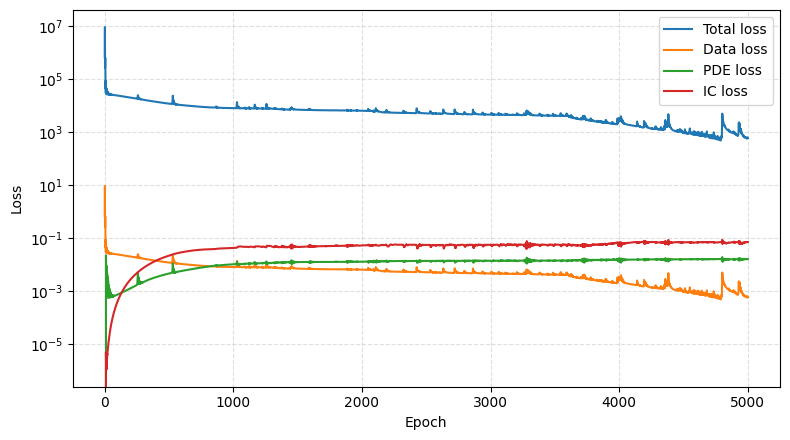

In [102]:
# ======================================================================
# 0) Imports ------------------------------------------------------------
# ======================================================================
import math
import numpy as np                     # ← 누락되어 있던 numpy import 추가
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt        # ← 시각화를 위한 import

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

# ======================================================================
# 2) 상수 & 정규화 계수 -------------------------------------------------
# ======================================================================
T_norm = torch.linspace(0, 1, 300)            # 정규화 시간축 (길이 L=300)
dt      = (T_norm[1]-T_norm[0]).item()        # 1/299

R_Norm, L_Norm, C_Norm = 1e-14, 1e-11, 1e16
Ud_Norm, Q_Norm        = 1e-8,  1e-2          # q·Ud 무차원화

# ======================================================================
# 4) DeepONet -----------------------------------------------------------
#   - Branch-1 입력 차원: 5 (p 제거: [mu, sigma, rho, c, t])
# ======================================================================
def mlp(d_in, hid, d_out):
    layers, h_prev = [], d_in
    for h in hid:
        layers += [nn.Linear(h_prev, h), nn.GELU()]
        h_prev = h
    layers.append(nn.Linear(h_prev, d_out))
    return nn.Sequential(*layers)

class DeepONet(nn.Module):
    def __init__(self, seq_len=300, latent=256,
                 branch1_hid=[256, 256, 256, 256, 256, 256],      # 5 layers
                 branch2_hid=[256, 256, 256, 256, 256,256],      # 5 layers
                 trunk_hid=[256, 256, 256, 256, 256, 256],        # 5 layers
                 gate_hid=[256]*7):                         # 10 layers
        super().__init__()

        self.branch1 = mlp(5,        branch1_hid, latent)   # (Input=5)
        self.branch2 = mlp(seq_len,  branch2_hid, latent)   # (Input=300)
        self.trunk   = mlp(1,        trunk_hid,   latent)   # (Input=1)
        self.gate    = mlp(1,        gate_hid,    latent)   # (Input=1)
        self.bias    = nn.Parameter(torch.zeros(1, seq_len))

        # Time grid normalization
        t = torch.linspace(1, seq_len, seq_len).view(-1, 1) / seq_len
        self.register_buffer("t_grid", t)

    def forward(self, x1, x2):
        # x1: (B,5), x2: (B,300)
        B = self.branch1(x1) + self.branch2(x2)     # (B, latent)
        T = self.trunk(self.t_grid)                 # (L, latent)
        G = torch.sigmoid(self.gate(self.t_grid))   # (L, latent)
        return B @ (T * G).T + self.bias            # (B, L=300)

# Device 설정 및 모델 초기화
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = DeepONet().to(DEVICE)

# ======================================================================
# 5) Physics helper -----------------------------------------------------
#   - 스칼라 인덱싱: mu(0), sigma(1), rho(2), c(3), t(4)
# ======================================================================
def physics_terms(q, scal, v):
    # scal: (B,5) = [mu, sigma, rho, c, t]
    mu     = scal[:, 0:1]
    sigma  = scal[:, 1:2]  # 현재 식에서는 미사용(확장 시 활용 가능)
    rho    = scal[:, 2:3]
    c      = scal[:, 3:4]
    t_pin  = scal[:, 4:5]  # 현재 항에서는 직접 사용하지 않음

    # 기하/상수
    l1,l2,l3,l4 = 0.012, 0.0084, 0.00542303, 0.00057697
    L_tot       = l1 + l2 + l3 + l4
    r_ch        = 235e-6
    alpha_pzt   = 0.29e-9

    # 점성 경계층 두께 근사 및 무차원화 계수
    T_visc  = 2 * L_tot / c
    delta_v = torch.sqrt(mu * T_visc / math.pi / rho)

    R_nd = 2 * mu * L_tot / (math.pi * delta_v * r_ch**3) * R_Norm
    L_nd = rho * L_tot / (math.pi * r_ch**2)              * L_Norm
    C_nd = math.pi * r_ch**2 * L_tot / (c**2 * rho)       * C_Norm

    # 중앙차분 (길이 L → 내부  L-2)
    dq_nd  = (q[:, 2:] - q[:, :-2]) / (2 * dt) * Q_Norm
    d2q_nd = (q[:, :-2] - 2*q[:, 1:-1] + q[:, 2:]) / (dt**2) * Q_Norm
    q_mid  =  q[:, 1:-1] * Q_Norm

    dVdt   = (v[:, 2:] - v[:, :-2]) / (2 * dt)
    Ud1    = (rho * c**2 * alpha_pzt * 2 / r_ch) * dVdt
    Ud_nd  = Ud1 * Ud_Norm

    return R_nd, L_nd, C_nd, Ud_nd, dq_nd, d2q_nd, q_mid

# ----------------------------------------------------------------------
# Losses
# ----------------------------------------------------------------------
def data_loss(q_pred, q_true):
    return torch.mean((q_pred - q_true).pow(2))

def pde_loss(q_pred, scal, v):
    R_nd, L_nd, C_nd, Ud_nd, dq_nd, d2q_nd, q_mid = physics_terms(q_pred, scal, v)
    resid = L_nd * d2q_nd + R_nd * dq_nd + q_mid / C_nd - Ud_nd
    return torch.mean(resid.pow(2))

def ic_loss(q_pred, scal, v):
    L_nd, *_ = physics_terms(q_pred, scal, v)
    q0_nd  = q_pred[:, 0] * Q_Norm
    dq0_nd = (q_pred[:, 1] - q_pred[:, 0]) / dt * Q_Norm
    v0_nd  = v[:, 0] * Ud_Norm
    return torch.mean(q0_nd.pow(2) + (L_nd.squeeze(-1) * dq0_nd - v0_nd).pow(2))

# ======================================================================
# 6) Training loop (+ 시각화 기록) --------------------------------------
# ======================================================================
EPOCHS, PHYS_ON     = 5000, 10
DATA_W, PDE_W, IC_W = 1e6, 1e-2, 1e-2
loader   = DataLoader(dataset, batch_size=300, shuffle=True)
optim    = torch.optim.Adam(model.parameters(), lr=5e-4)

# ----- 기록용 컨테이너 -------------------------------------------------
hist = {
    "epoch": [],
    "total": [],
    "data":  [],
    "pde":   [],
    "ic":    []
}

for ep in range(1, EPOCHS + 1):
    model.train()
    sum_tot = 0.0
    sum_d   = 0.0
    sum_p   = 0.0
    sum_i   = 0.0

    for x1, x2, y in loader:
        x1, x2, y = x1.to(DEVICE), x2.to(DEVICE), y.to(DEVICE)  # x1:(B,5), x2:(B,300)
        q_pred    = model(x1, x2)                                # (B,300)

        l_d = data_loss(q_pred, y)
        if ep >= PHYS_ON:
            l_p = pde_loss(q_pred, x1, x2)
            l_i = ic_loss(q_pred, x1, x2)
        else:
            l_p = torch.tensor(0.0, device=DEVICE)
            l_i = torch.tensor(0.0, device=DEVICE)

        loss = DATA_W*l_d + PDE_W*l_p + IC_W*l_i

        optim.zero_grad()
        loss.backward()
        optim.step()

        # 배치 합계(에폭 평균 계산용)
        sum_tot += float(loss.detach())
        sum_d   += float(l_d.detach())
        sum_p   += float(l_p.detach())
        sum_i   += float(l_i.detach())

    # 에폭 평균 기록
    n_batch = len(loader)
    mean_tot = sum_tot / n_batch
    mean_d   = sum_d   / n_batch
    mean_p   = sum_p   / n_batch
    mean_i   = sum_i   / n_batch

    hist["epoch"].append(ep)
    hist["total"].append(mean_tot)
    hist["data"].append(mean_d)
    hist["pde"].append(mean_p)
    hist["ic"].append(mean_i)

    if ep == 1 or ep % 200 == 0:
        print(f"[{ep:4d}] mean loss {mean_tot:.3e} | data {mean_d:.3e} | pde {mean_p:.3e} | ic {mean_i:.3e}")

# ======================================================================
# 7) 시각화 -------------------------------------------------------------
# ======================================================================
plt.figure(figsize=(8,4.5))
plt.plot(hist["epoch"], hist["total"], label="Total loss")
plt.plot(hist["epoch"], hist["data"],  label="Data loss")
plt.plot(hist["epoch"], hist["pde"],   label="PDE loss")
plt.plot(hist["epoch"], hist["ic"],    label="IC loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")               # 손실이 급격히 줄 때 가독성 향상
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curves.png", dpi=150, bbox_inches="tight")
plt.show()


---

[Metrics @ v24]  MSE=3.671337e-04  MAE=1.336368e-02  Pearson r=0.9909


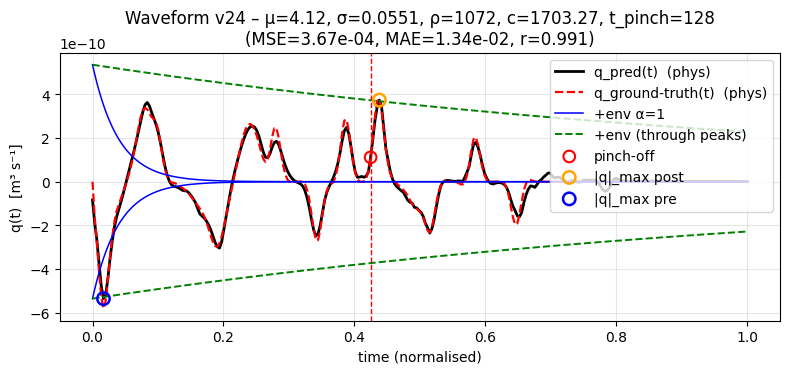

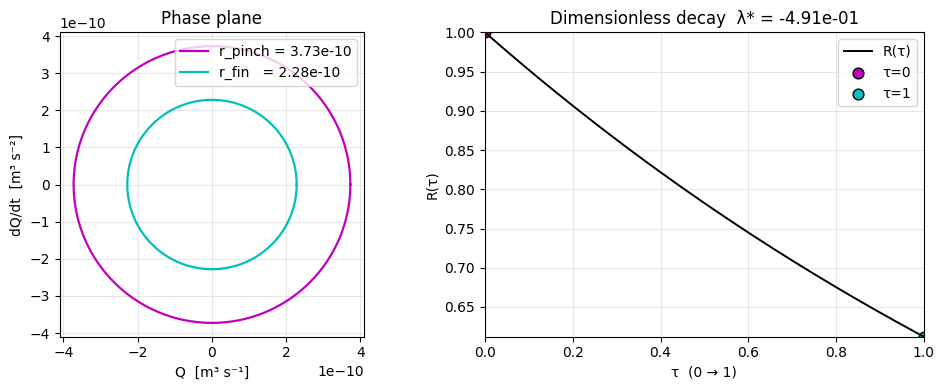

In [104]:
# ======================================================================
# 0) Imports & DEVICE ---------------------------------------------------
# ======================================================================
import math, os, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ======================================================================
# 7) expo_decay (시각화용)  ← 스칼라 5개 체계로 수정 -------------------
# ======================================================================
def expo_decay(q_pred, scal_row, t_pinch_idx):
    """
    q_pred      : (300,) numpy  – 모델 예측(무차원 q)
    scal_row    : (5,)          – (μ, σ, ρ, c, t_pinch)
    t_pinch_idx : int           – 0-based pinch index (t_pinch-1)
    반환: dict (모든 좌표·envelope)
    """
    t_norm = np.linspace(0, 1, 300)
    q_arr  = q_pred.copy()

    idx_pin   = t_pinch_idx
    t_star    = t_norm[idx_pin]
    q_star    = q_arr[idx_pin]

    # post-pinch
    idx_amp = t_amp = q_amp = None
    if idx_pin+1 < len(q_arr):
        post_q    = q_arr[idx_pin+1:]
        idx_rel   = np.argmax(np.abs(post_q))
        idx_amp   = idx_pin+1+idx_rel
        t_amp, q_amp = t_norm[idx_amp], q_arr[idx_amp]

    # pre-pinch
    idx_pre = t_pre = q_pre = None
    if idx_pin > 0:
        pre_q   = q_arr[:idx_pin]
        idx_pre = np.argmax(np.abs(pre_q))
        t_pre, q_pre = t_norm[idx_pre], q_arr[idx_pre]

    # ------------------------------  물성 파생 파라미터 (예: 감쇠)  ------------------------------
    mu, sigma, rho, c, t_pinch = scal_row
    l1,l2,l3,l4 = 0.012, 0.0084, 0.00542303, 0.00057697
    L_tot, r_ch = l1+l2+l3+l4, 235e-6
    T_visc = 2*L_tot / c
    delta_v= math.sqrt(mu*T_visc/math.pi/rho)
    R = 2*mu*L_tot/(math.pi*delta_v*r_ch**3)
    L = rho*L_tot/(math.pi*r_ch**2)
    C = math.pi*r_ch**2*L_tot/(c**2*rho)

    zeta    = R / (2*math.sqrt(L/C))
    omega_n = 1.0 / math.sqrt(L*C)

    # ------------------------------  envelope & 물리 스케일 변환  ------------------------------
    scale = 1e-9
    q_phys = q_arr*scale
    t_s    = t_norm*300e-6
    A_env  = np.max(np.abs(q_phys))
    env_a1 =  A_env*np.exp(-1.0*zeta*omega_n*t_s)

    env_cust = None
    if (idx_pre is not None) and (idx_amp is not None):
        t_pre_s = t_pre*300e-6
        t_amp_s = t_amp*300e-6
        denom = (zeta*omega_n*(t_amp_s - t_pre_s))
        if denom != 0 and (abs(q_pre) > 0) and (abs(q_amp) > 0):
            alpha_c = (np.log(abs(q_pre*scale)/abs(q_amp*scale)) / denom)
            env_cust = A_env*np.exp(-alpha_c*zeta*omega_n*t_s)

    return dict(t=t_norm, q=q_phys,
                idx_pin=idx_pin, t_star=t_star, q_star=q_star*scale,
                idx_amp=idx_amp, t_amp=t_amp, q_amp=q_amp*scale if q_amp is not None else None,
                idx_pre=idx_pre, t_pre=t_pre, q_pre=q_pre*scale if q_pre is not None else None,
                env_a1=env_a1, env_cust=env_cust)

def decay_rate(env: dict):
    """
    env : expo_decay()가 돌려준 dict
    반환 : None  (env_cust가 없으면)  또는
           {lam_star, r_pinch, r_fin, tau, R_tau}
    """
    env_c = env["env_cust"]
    if env_c is None:
        return None

    idx_p   = env["idx_pin"]
    r_pinch = abs(env_c[idx_p])             # |q| at pinch (envelope 값)
    r_fin   = abs(env_c[-1])                # |q| at t_norm = 1

    t       = env["t"]
    tau     = (t - t[idx_p]) / (t[-1] - t[idx_p])     # 0 → 1
    R_tau   = env_c / r_pinch
    mask    = (tau >= 0) & (tau <= 1)
    tau_seg = tau[mask]
    R_seg   = R_tau[mask]

    lam_star = math.log(r_fin / r_pinch) if r_pinch > 0 and r_fin > 0 else float('nan')

    return dict(lam_star=lam_star,
                r_pinch=r_pinch, r_fin=r_fin,
                tau=tau_seg, R_tau=R_seg)

# ======================================================================
# 8) Exponential decay & visualization  +  GT(원 데이터) 비교 ----------
# ======================================================================
# 전처리 블록에서 생성한 사전들을 그대로 사용:
#   - WAVE_DB : waveform_id → v1..v300 (np.float32)
#   - GT_DB   : waveform_id → q1..q300 (np.float32)

# 예측 입력 구성 (★ x1/x2 분리 인덱스 5로 수정)
single = (4.12, 0.0551, 1072, 1703.27, 128, "v24")   # 5 scalars + id
mu, sigma, rho, c_val, t_pinch, wid = single

v_wave = WAVE_DB[wid]  # (300,)

x_np  = np.concatenate([[mu, sigma, rho, c_val, t_pinch], v_wave]).astype(np.float32)
x1_np, x2_np = x_np[:5], x_np[5:]

model.eval()
with torch.no_grad():
    q_out = model(torch.from_numpy(x1_np).unsqueeze(0).to(DEVICE),
                  torch.from_numpy(x2_np).unsqueeze(0).to(DEVICE)
                 ).squeeze(0).cpu().numpy()   # (300,)  — 예측(무차원)

# 정답(무차원) 불러오기
if wid not in GT_DB:
    raise KeyError(f"waveform_id {wid} not found in GT_DB.")
q_gt = GT_DB[wid].astype(np.float32)          # (300,) — 원래 Y (무차원)

# expo_decay는 내부에서 예측을 물리단위(×1e-9)로 변환하여 반환
ed = expo_decay(q_out, np.array([mu, sigma, rho, c_val, t_pinch], dtype=np.float64), t_pinch-1)

# 원 데이터도 같은 스케일(물리 단위)로 일관 변환
scale = 1e-9
q_gt_phys = q_gt * scale

# ------------------  정량 지표 ------------------
mse = float(np.mean((q_out - q_gt)**2))
mae = float(np.mean(np.abs(q_out - q_gt)))
# Pearson r: 분산 0 방지
if (np.std(q_out) > 0) and (np.std(q_gt) > 0):
    r = float(np.corrcoef(q_out, q_gt)[0,1])
else:
    r = np.nan

print(f"[Metrics @ {wid}]  MSE={mse:.6e}  MAE={mae:.6e}  Pearson r={r:.4f}")

# ------------------  시각화 (예측 vs 원데이터) ------------------
plt.figure(figsize=(8,4))
plt.plot(ed['t'], ed['q'], 'k', lw=2, label='q_pred(t)  (phys)')
plt.plot(ed['t'], q_gt_phys, 'r--', lw=1.6, label='q_ground-truth(t)  (phys)')
plt.plot(ed['t'],  ed['env_a1'], 'b-', lw=1.1, label='+env α=1')
plt.plot(ed['t'], -ed['env_a1'], 'b-', lw=1.1)

if ed['env_cust'] is not None:
    plt.plot(ed['t'],  ed['env_cust'], 'g--', lw=1.4, label='+env (through peaks)')
    plt.plot(ed['t'], -ed['env_cust'], 'g--', lw=1.4)

plt.axvline(ed['t_star'], color='red', ls='--', lw=1)
plt.scatter(ed['t_star'], ed['q_star'], s=70, facecolors='none',
            edgecolors='red', linewidths=1.5, zorder=3, label='pinch-off')

if ed['idx_amp'] is not None:
    plt.scatter(ed['t_amp'], ed['q_amp'], s=80, facecolors='none',
                edgecolors='orange', linewidths=1.8, zorder=3,
                label='|q|_max post')
if ed['idx_pre'] is not None:
    plt.scatter(ed['t_pre'], ed['q_pre'], s=80, facecolors='none',
                edgecolors='blue', linewidths=1.8, zorder=3,
                label='|q|_max pre')

plt.xlabel('time (normalised)')
plt.ylabel('q(t)  [m³ s⁻¹]')
plt.title(f"Waveform {wid} – μ={mu}, σ={sigma}, ρ={rho}, c={c_val}, t_pinch={t_pinch}\n"
          f"(MSE={mse:.2e}, MAE={mae:.2e}, r={r:.3f})")
plt.grid(alpha=.3); plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

# ======================================================================
# 9) Decay-rate ‧ phase-plane 시각화 -----------------------------------
# ======================================================================
dr = decay_rate(ed)
if dr is None:
    print("[skip] env_cust 없음 → λ* subplot 생략")
else:
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(10, 4))

    # (좌) phase plane : r_pinch, r_fin 원
    theta = np.linspace(0, 2*np.pi, 361)
    axL.plot(dr['r_pinch']*np.cos(theta), dr['r_pinch']*np.sin(theta),
             'm-', lw=1.6, label=f"r_pinch = {dr['r_pinch']:.2e}")
    axL.plot(dr['r_fin']  *np.cos(theta), dr['r_fin']  *np.sin(theta),
             'c-', lw=1.6, label=f"r_fin   = {dr['r_fin']:.2e}")
    axL.set_aspect("equal");   axL.grid(alpha=.3)
    axL.set_xlabel("Q  [m³ s⁻¹]")
    axL.set_ylabel("dQ/dt  [m³ s⁻²]")
    axL.set_title("Phase plane");   axL.legend(loc="upper right")

    # (우) R(τ) 곡선
    axR.plot(dr['tau'], dr['R_tau'], 'k-', lw=1.4, label="R(τ)")
    axR.scatter(0, 1,                          c='m', edgecolors='k', s=60, label="τ=0")
    axR.scatter(1, dr['r_fin']/dr['r_pinch'],  c='c', edgecolors='k', s=60, label="τ=1")
    axR.set_xlim(0, 1)
    axR.set_ylim(min(dr['R_tau'].min(), 1.0), max(dr['R_tau'].max(), 1.0))
    axR.set_xlabel("τ  (0 → 1)")
    axR.set_ylabel("R(τ)")
    axR.set_title(fr"Dimensionless decay  λ* = {dr['lam_star']:.2e}")
    axR.grid(alpha=.3);   axR.legend(loc="upper right")

    plt.tight_layout();   plt.show()


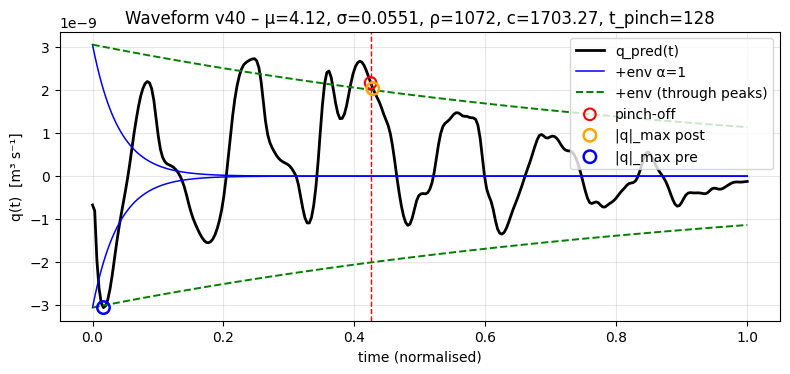

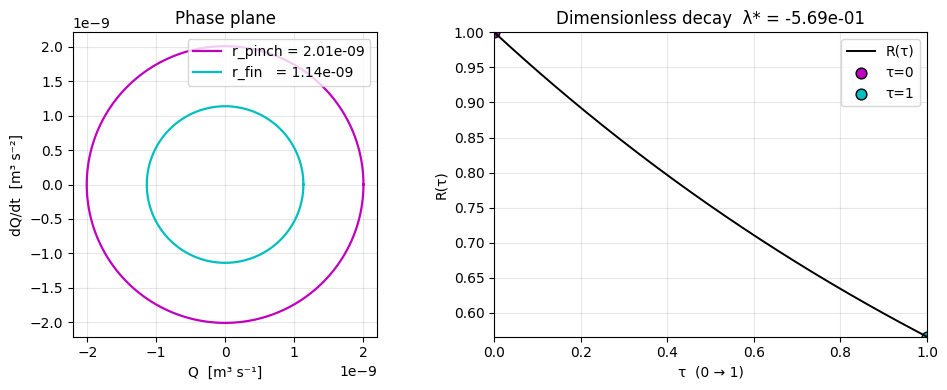

In [27]:
# ======================================================================
# 0) Imports & DEVICE ---------------------------------------------------
# ======================================================================
import math, os, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ======================================================================
# 7) expo_decay (시각화용)  ← 스칼라 5개 체계로 수정 -------------------
# ======================================================================
def expo_decay(q_pred, scal_row, t_pinch_idx):
    """
    q_pred      : (300,) numpy  – 모델 예측(무차원 q)
    scal_row    : (5,)          – (μ, σ, ρ, c, t_pinch)   ★ 6 → 5
    t_pinch_idx : int           – 0-based pinch index (t_pinch-1)
    반환: dict (모든 좌표·envelope)
    """
    # ------------------------------
    # 1. pre/post-pinch max 검색
    # ------------------------------
    t_norm = np.linspace(0, 1, 300)
    q_arr  = q_pred.copy()

    idx_pin   = t_pinch_idx
    t_star    = t_norm[idx_pin]
    q_star    = q_arr[idx_pin]

    # post-pinch
    idx_amp = t_amp = q_amp = None
    if idx_pin+1 < len(q_arr):
        post_q    = q_arr[idx_pin+1:]
        idx_rel   = np.argmax(np.abs(post_q))
        idx_amp   = idx_pin+1+idx_rel
        t_amp, q_amp = t_norm[idx_amp], q_arr[idx_amp]

    # pre-pinch
    idx_pre = t_pre = q_pre = None
    if idx_pin > 0:
        pre_q   = q_arr[:idx_pin]
        idx_pre = np.argmax(np.abs(pre_q))
        t_pre, q_pre = t_norm[idx_pre], q_arr[idx_pre]

    # ------------------------------
    # 2. 비정규화 R,L,C 계산 (p_level 제거)
    # ------------------------------
    mu, sigma, rho, c, t_pinch = scal_row  # ★ 5개 언패킹
    l1,l2,l3,l4 = 0.012, 0.0084, 0.00542303, 0.00057697
    L_tot, r_ch = l1+l2+l3+l4, 235e-6
    T_visc = 2*L_tot / c
    delta_v= math.sqrt(mu*T_visc/math.pi/rho)
    R = 2*mu*L_tot/(math.pi*delta_v*r_ch**3)
    L = rho*L_tot/(math.pi*r_ch**2)
    C = math.pi*r_ch**2*L_tot/(c**2*rho)

    zeta    = R / (2*math.sqrt(L/C))
    omega_n = 1.0 / math.sqrt(L*C)

    # ------------------------------
    # 3. envelope 계산
    # ------------------------------
    scale = 1e-9
    q_phys = q_arr*scale
    t_s    = t_norm*300e-6
    A_env  = np.max(np.abs(q_phys))
    env_a1 =  A_env*np.exp(-1.0*zeta*omega_n*t_s)

    env_cust = None
    if (idx_pre is not None) and (idx_amp is not None):
        t_pre_s = t_pre*300e-6
        t_amp_s = t_amp*300e-6
        # 방어적 분모 보호
        denom = (zeta*omega_n*(t_amp_s - t_pre_s))
        if denom != 0 and (abs(q_pre) > 0) and (abs(q_amp) > 0):
            alpha_c = (np.log(abs(q_pre*scale)/abs(q_amp*scale)) / denom)
            env_cust = A_env*np.exp(-alpha_c*zeta*omega_n*t_s)

    return dict(t=t_norm, q=q_phys,
                idx_pin=idx_pin, t_star=t_star, q_star=q_star*scale,
                idx_amp=idx_amp, t_amp=t_amp, q_amp=q_amp*scale if q_amp is not None else None,
                idx_pre=idx_pre, t_pre=t_pre, q_pre=q_pre*scale if q_pre is not None else None,
                env_a1=env_a1, env_cust=env_cust)

def decay_rate(env: dict):
    """
    env : expo_decay()가 돌려준 dict
    반환 : None  (env_cust가 없으면)  또는
           {lam_star, r_pinch, r_fin, tau, R_tau}
    """
    env_c = env["env_cust"]
    if env_c is None:
        return None

    idx_p   = env["idx_pin"]
    r_pinch = abs(env_c[idx_p])             # |q| at pinch (envelope 값)
    r_fin   = abs(env_c[-1])                # |q| at t_norm = 1

    t       = env["t"]
    tau     = (t - t[idx_p]) / (t[-1] - t[idx_p])     # 0 → 1
    R_tau   = env_c / r_pinch
    mask    = (tau >= 0) & (tau <= 1)
    tau_seg = tau[mask]
    R_seg   = R_tau[mask]

    lam_star = math.log(r_fin / r_pinch) if r_pinch > 0 and r_fin > 0 else float('nan')

    return dict(lam_star=lam_star,
                r_pinch=r_pinch, r_fin=r_fin,
                tau=tau_seg, R_tau=R_seg)

# ======================================================================
# 8) Exponential decay & visualization ---------------------------------
# ======================================================================
# 예측 입력 구성 (★ x1/x2 분리 인덱스 5로 수정)
single = (4.12, 0.0551, 1072, 1703.27, 128, "v40")   # 5 scalars + id
mu, sigma, rho, c_val, t_pinch, wid = single

v_wave = WAVE_DB[wid]  # (300,)

x_np  = np.concatenate([[mu, sigma, rho, c_val, t_pinch], v_wave]).astype(np.float32)
x1_np, x2_np = x_np[:5], x_np[5:]  # ★ 6→5 로 수정

model.eval()
with torch.no_grad():
    q_out = model(torch.from_numpy(x1_np).unsqueeze(0).to(DEVICE),
                  torch.from_numpy(x2_np).unsqueeze(0).to(DEVICE)
                 ).squeeze(0).cpu().numpy()

# expo_decay 호출도 5개 스칼라로 전달
ed = expo_decay(q_out, np.array([mu, sigma, rho, c_val, t_pinch], dtype=np.float64), t_pinch-1)

# ------------------  시각화 ------------------
plt.figure(figsize=(8,4))
plt.plot(ed['t'], ed['q'], 'k', lw=2, label='q_pred(t)')
plt.plot(ed['t'],  ed['env_a1'], 'b-', lw=1.1, label='+env α=1')
plt.plot(ed['t'], -ed['env_a1'], 'b-', lw=1.1)

if ed['env_cust'] is not None:
    plt.plot(ed['t'],  ed['env_cust'], 'g--', lw=1.4, label='+env (through peaks)')
    plt.plot(ed['t'], -ed['env_cust'], 'g--', lw=1.4)

plt.axvline(ed['t_star'], color='red', ls='--', lw=1)
plt.scatter(ed['t_star'], ed['q_star'], s=70, facecolors='none',
            edgecolors='red', linewidths=1.5, zorder=3, label='pinch-off')

if ed['idx_amp'] is not None:
    plt.scatter(ed['t_amp'], ed['q_amp'], s=80, facecolors='none',
                edgecolors='orange', linewidths=1.8, zorder=3,
                label='|q|_max post')
if ed['idx_pre'] is not None:
    plt.scatter(ed['t_pre'], ed['q_pre'], s=80, facecolors='none',
                edgecolors='blue', linewidths=1.8, zorder=3,
                label='|q|_max pre')

plt.xlabel('time (normalised)')
plt.ylabel('q(t)  [m³ s⁻¹]')
plt.title(f"Waveform {wid} – μ={mu}, σ={sigma}, ρ={rho}, c={c_val}, t_pinch={t_pinch}")
plt.grid(alpha=.3); plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

# ======================================================================
# 9) Decay-rate ‧ phase-plane 시각화 -----------------------------------
# ======================================================================
dr = decay_rate(ed)
if dr is None:
    print("[skip] env_cust 없음 → λ* subplot 생략")
else:
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(10, 4))

    # (좌) phase plane : r_pinch, r_fin 원
    theta = np.linspace(0, 2*np.pi, 361)
    axL.plot(dr['r_pinch']*np.cos(theta), dr['r_pinch']*np.sin(theta),
             'm-', lw=1.6, label=f"r_pinch = {dr['r_pinch']:.2e}")
    axL.plot(dr['r_fin']  *np.cos(theta), dr['r_fin']  *np.sin(theta),
             'c-', lw=1.6, label=f"r_fin   = {dr['r_fin']:.2e}")
    axL.set_aspect("equal");   axL.grid(alpha=.3)
    axL.set_xlabel("Q  [m³ s⁻¹]")
    axL.set_ylabel("dQ/dt  [m³ s⁻²]")
    axL.set_title("Phase plane");   axL.legend(loc="upper right")

    # (우) R(τ) 곡선
    axR.plot(dr['tau'], dr['R_tau'], 'k-', lw=1.4, label="R(τ)")
    axR.scatter(0, 1,                          c='m', edgecolors='k', s=60, label="τ=0")
    axR.scatter(1, dr['r_fin']/dr['r_pinch'],  c='c', edgecolors='k', s=60, label="τ=1")
    axR.set_xlim(0, 1)
    axR.set_ylim(min(dr['R_tau'].min(), 1.0), max(dr['R_tau'].max(), 1.0))
    axR.set_xlabel("τ  (0 → 1)")
    axR.set_ylabel("R(τ)")
    axR.set_title(fr"Dimensionless decay  λ* = {dr['lam_star']:.2e}")
    axR.grid(alpha=.3);   axR.legend(loc="upper right")

    plt.tight_layout();   plt.show()


---

In [19]:
# ======================================================================
# 8) Exponential decay & visualization ---------------------------------
# ======================================================================
# 예측 입력 구성 (★ x1/x2 분리 인덱스 5로 수정)
single = (15.76, 0.0474, 1114, 1688, 118, "v20")   # 5 scalars + id
mu, sigma, rho, c_val, t_pinch, wid = single

v_wave = WAVE_DB[wid]  # (300,)

x_np  = np.concatenate([[mu, sigma, rho, c_val, t_pinch], v_wave]).astype(np.float32)
x1_np, x2_np = x_np[:5], x_np[5:]  # ★ 6→5 로 수정

model.eval()
with torch.no_grad():
    q_out = model(torch.from_numpy(x1_np).unsqueeze(0).to(DEVICE),
                  torch.from_numpy(x2_np).unsqueeze(0).to(DEVICE)
                 ).squeeze(0).cpu().numpy()

# expo_decay 호출도 5개 스칼라로 전달
ed = expo_decay(q_out, np.array([mu, sigma, rho, c_val, t_pinch], dtype=np.float64), t_pinch-1)

# ------------------  시각화 ------------------
plt.figure(figsize=(8,4))
plt.plot(ed['t'], ed['q'], 'k', lw=2, label='q_pred(t)')
plt.plot(ed['t'],  ed['env_a1'], 'b-', lw=1.1, label='+env α=1')
plt.plot(ed['t'], -ed['env_a1'], 'b-', lw=1.1)

if ed['env_cust'] is not None:
    plt.plot(ed['t'],  ed['env_cust'], 'g--', lw=1.4, label='+env (through peaks)')
    plt.plot(ed['t'], -ed['env_cust'], 'g--', lw=1.4)

plt.axvline(ed['t_star'], color='red', ls='--', lw=1)
plt.scatter(ed['t_star'], ed['q_star'], s=70, facecolors='none',
            edgecolors='red', linewidths=1.5, zorder=3, label='pinch-off')

if ed['idx_amp'] is not None:
    plt.scatter(ed['t_amp'], ed['q_amp'], s=80, facecolors='none',
                edgecolors='orange', linewidths=1.8, zorder=3,
                label='|q|_max post')
if ed['idx_pre'] is not None:
    plt.scatter(ed['t_pre'], ed['q_pre'], s=80, facecolors='none',
                edgecolors='blue', linewidths=1.8, zorder=3,
                label='|q|_max pre')

plt.xlabel('time (normalised)')
plt.ylabel('q(t)  [m³ s⁻¹]')
plt.title(f"Waveform {wid} – μ={mu}, σ={sigma}, ρ={rho}, c={c_val}, t_pinch={t_pinch}")
plt.grid(alpha=.3); plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

# ======================================================================
# 9) Decay-rate ‧ phase-plane 시각화 -----------------------------------
# ======================================================================
dr = decay_rate(ed)
if dr is None:
    print("[skip] env_cust 없음 → λ* subplot 생략")
else:
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(10, 4))

    # (좌) phase plane : r_pinch, r_fin 원
    theta = np.linspace(0, 2*np.pi, 361)
    axL.plot(dr['r_pinch']*np.cos(theta), dr['r_pinch']*np.sin(theta),
             'm-', lw=1.6, label=f"r_pinch = {dr['r_pinch']:.2e}")
    axL.plot(dr['r_fin']  *np.cos(theta), dr['r_fin']  *np.sin(theta),
             'c-', lw=1.6, label=f"r_fin   = {dr['r_fin']:.2e}")
    axL.set_aspect("equal");   axL.grid(alpha=.3)
    axL.set_xlabel("Q  [m³ s⁻¹]")
    axL.set_ylabel("dQ/dt  [m³ s⁻²]")
    axL.set_title("Phase plane");   axL.legend(loc="upper right")

    # (우) R(τ) 곡선
    axR.plot(dr['tau'], dr['R_tau'], 'k-', lw=1.4, label="R(τ)")
    axR.scatter(0, 1,                          c='m', edgecolors='k', s=60, label="τ=0")
    axR.scatter(1, dr['r_fin']/dr['r_pinch'],  c='c', edgecolors='k', s=60, label="τ=1")
    axR.set_xlim(0, 1)
    axR.set_ylim(min(dr['R_tau'].min(), 1.0), max(dr['R_tau'].max(), 1.0))
    axR.set_xlabel("τ  (0 → 1)")
    axR.set_ylabel("R(τ)")
    axR.set_title(fr"Dimensionless decay  λ* = {dr['lam_star']:.2e}")
    axR.grid(alpha=.3);   axR.legend(loc="upper right")

    plt.tight_layout();   plt.show()


NameError: name 'expo_decay' is not defined

In [9]:
# ────────────────────────────────────────────────────────────────
# (A) BO objective : dimensionless decay index λ*
#       candidate  = (μ, σ, ρ, c, p_level, t_us, wave_id)
#       returns    = float (smaller is better)
# ────────────────────────────────────────────────────────────────
import numpy as np
import torch

def bo_objective(candidate,
                 model,
                 wave_db,
                 device: torch.device = torch.device("cpu")) -> float:
    """
    Parameters
    ----------
    candidate : tuple
        (mu, sigma, rho, c_val, t_us, wave_id)
    model     : torch.nn.Module
        Trained DeepONet that maps (x1, x2) -> q̂
    wave_db   : dict
        Mapping  wave_id -> (300,) numpy array of the driving waveform
    device    : torch.device
        CUDA / CPU device on which to run the model

    Returns
    -------
    float
        λ*  (more-negative ⇒ faster decay).  Raises if waveform or index is invalid.
    """
    # ── unpack candidate tuple ───────────────────────────────────────
    mu, sigma, rho, c_val, t_us, wid = candidate

    # ── fetch waveform & sanity-check ────────────────────────────────
    try:
        wave = wave_db[wid]
    except KeyError as e:
        raise KeyError(f"wave_id '{wid}' not found in wave_db") from e
    if wave.shape[0] != 300:
        raise ValueError("waveform length must be exactly 300")

    # ── build DeepONet inputs ───────────────────────────────────────
    x1_np = np.array([mu, sigma, rho, c_val, t_us],
                     dtype=np.float32)           # (6,)
    x2_np = wave.astype(np.float32)              # (300,)

    x1 = torch.from_numpy(x1_np).unsqueeze(0).to(device)  # (1, 6)
    x2 = torch.from_numpy(x2_np).unsqueeze(0).to(device)  # (1, 300)

    # ── forward pass ────────────────────────────────────────────────
    model.eval()
    with torch.no_grad():
        q_hat = model(x1, x2).squeeze(0)         # (300,)

    # ── compute λ*  (= ln(r_fin / r_pinch)) ─────────────────────────
    idx_pinch = int(t_us) - 1                    # 0-based
    if not 0 <= idx_pinch < 300:
        raise ValueError("t_us must map to an index between 1 and 300")

    r_pinch = q_hat[idx_pinch].abs() + 1e-12     # avoid log(0)
    r_fin   = q_hat[-1].abs()       + 1e-12
    lam_star = torch.log(r_fin / r_pinch).item()

    return lam_star


# ────────────────────────────────────────────────────────────────
# (B) Expected Improvement (EI) for minimisation
#       μ, σ : GP posterior mean / std  (same tensor shape)
#       f_best: current best observed objective value
# ────────────────────────────────────────────────────────────────
import torch.distributions as D

def expected_improvement(mu: torch.Tensor,
                         sigma: torch.Tensor,
                         f_best: float) -> torch.Tensor:
    """
    EI(x) = (f_best - μ) Φ(z) + σ φ(z) ,
    z = (f_best - μ) / σ .
    Larger EI values indicate better candidates.

    Parameters
    ----------
    mu : torch.Tensor
        Posterior mean at candidate points.
    sigma : torch.Tensor
        Posterior standard deviation at candidate points.
    f_best : float
        Current minimum observed objective value.

    Returns
    -------
    torch.Tensor
        Expected Improvement for each candidate (same shape as μ).
    """
    sigma = sigma.clamp_min(1e-9)                 # avoid division by zero
    z = (f_best - mu) / sigma

    normal = D.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    Phi = normal.cdf(z)                           # Φ(z)
    phi = torch.exp(normal.log_prob(z))           # φ(z)

    ei = (f_best - mu) * Phi + sigma * phi
    return ei


In [10]:
rows = [
    #  μ     σ      ρ     c       t_us wave_id
    (15.76, 0.0474, 1114, 1679.5, 120, "v24"),
    (15.76, 0.0474, 1114, 1679.5, 121, "v26"),
    (15.76, 0.0474, 1114, 1679.5, 122, "v28"),
    (15.76, 0.0474, 1114, 1679.5, 123, "v30"),
    (15.76, 0.0474, 1114, 1679.5, 124, "v32"),
    (15.76, 0.0474, 1114, 1679.5, 125, "v34"),
    (15.76, 0.0474, 1114, 1679.5, 126, "v36"),
    (15.76, 0.0474, 1114, 1679.5, 127, "v38"),
    (15.76, 0.0474, 1114, 1679.5, 128, "v40"),
]
wave_ids = [r[-1] for r in rows]

lam_list = [bo_objective(cand, model, WAVE_DB, DEVICE) for cand in rows]

# 최소값과 대응 파라미터 가져오기
idx_min   = int(np.argmin(lam_list))
best_row  = rows[idx_min]
best_lam  = lam_list[idx_min]

print(f"λ* 최소 = {best_lam:+.3e}  →  {best_row}")

λ* 최소 = -4.123e+00  →  (15.76, 0.0474, 1114, 1679.5, 120, 'v24')


In [11]:
for cand, lam in zip(rows, lam_list):
    print(f"{cand[-1]} @ t={cand[5]} µs  →  λ*={lam:+.3e}")

v24 @ t=v24 µs  →  λ*=-4.123e+00
v26 @ t=v26 µs  →  λ*=-3.817e+00
v28 @ t=v28 µs  →  λ*=-2.952e+00
v30 @ t=v30 µs  →  λ*=-2.529e+00
v32 @ t=v32 µs  →  λ*=-2.218e+00
v34 @ t=v34 µs  →  λ*=-1.947e+00
v36 @ t=v36 µs  →  λ*=-1.702e+00
v38 @ t=v38 µs  →  λ*=-1.478e+00
v40 @ t=v40 µs  →  λ*=-1.283e+00


[Comp μ=15.76, σ=0.0474, ρ=1114, c=1688.0] min λ*=-4.197e+00 @ V=24 (wave=v24)
[Comp μ=10.52, σ=0.0497, ρ=1101, c=1688.0] min λ*=-5.570e+00 @ V=24 (wave=v24)
[Comp μ=6.46, σ=0.0521, ρ=1081, c=1709.38] min λ*=-5.794e+00 @ V=24 (wave=v24)
[Comp μ=4.95, σ=0.0539, ρ=1070, c=1707.98] min λ*=-5.923e+00 @ V=24 (wave=v24)
[Comp μ=4.12, σ=0.0551, ρ=1072, c=1703.27] min λ*=-6.591e+00 @ V=24 (wave=v24)
[Comp μ=3.07, σ=0.0565, ρ=1056, c=1683.21] min λ*=-6.612e+00 @ V=24 (wave=v24)


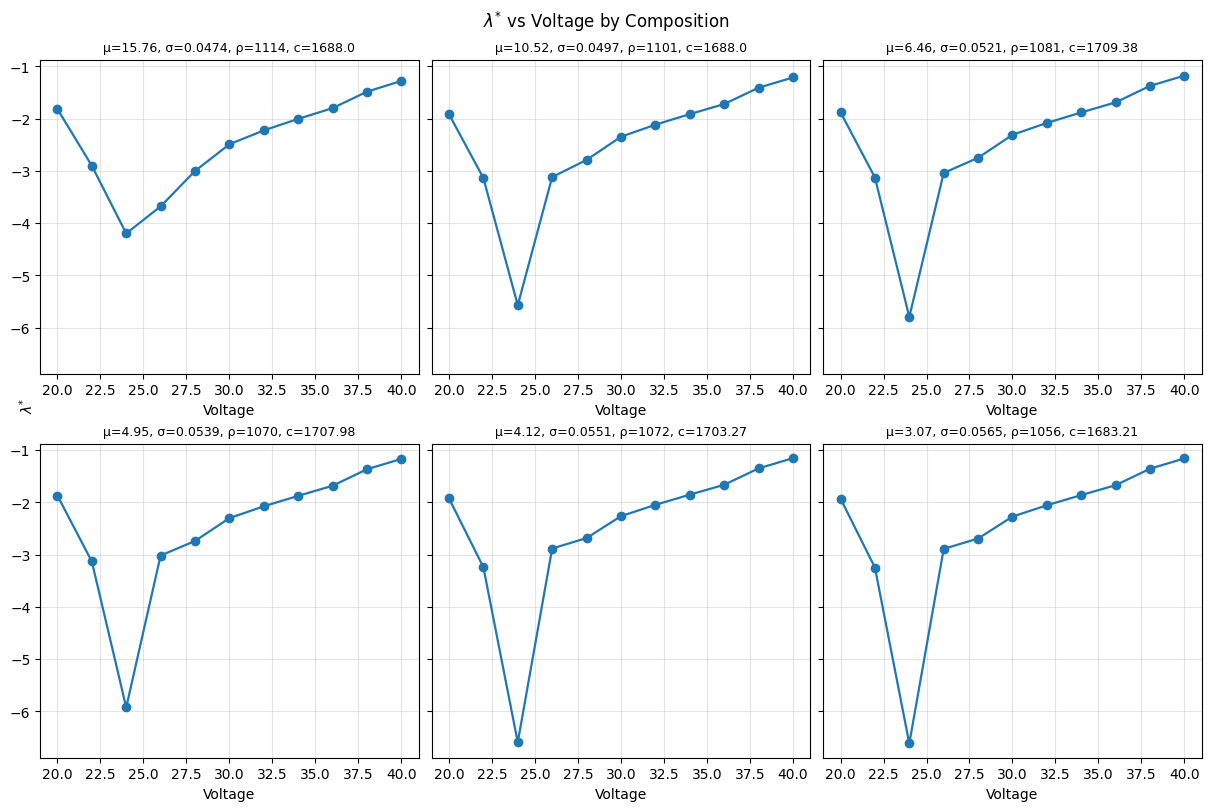

In [12]:
import io, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 1) 제공된 표 데이터를 그대로 사용 (Dummy data 아님)
# ─────────────────────────────────────────────────────────────
data_str = """mu	sigma	rho	c	t	V_name
15.76	0.0474	1114	1688	118	v20
15.76	0.0474	1114	1688	121	v22
15.76	0.0474	1114	1688	122	v24
15.76	0.0474	1114	1688	130	v26
15.76	0.0474	1114	1688	123	v28
15.76	0.0474	1114	1688	122	v30
15.76	0.0474	1114	1688	123	v32
15.76	0.0474	1114	1688	123	v34
15.76	0.0474	1114	1688	122	v36
15.76	0.0474	1114	1688	120	v38
15.76	0.0474	1114	1688	128	v40
10.52	0.0497	1101	1688	118	v20
10.52	0.0497	1101	1688	121	v22
10.52	0.0497	1101	1688	122	v24
10.52	0.0497	1101	1688	130	v26
10.52	0.0497	1101	1688	123	v28
10.52	0.0497	1101	1688	122	v30
10.52	0.0497	1101	1688	123	v32
10.52	0.0497	1101	1688	123	v34
10.52	0.0497	1101	1688	122	v36
10.52	0.0497	1101	1688	120	v38
10.52	0.0497	1101	1688	128	v40
6.46	0.0521	1081	1709.38	118	v20
6.46	0.0521	1081	1709.38	121	v22
6.46	0.0521	1081	1709.38	122	v24
6.46	0.0521	1081	1709.38	130	v26
6.46	0.0521	1081	1709.38	123	v28
6.46	0.0521	1081	1709.38	122	v30
6.46	0.0521	1081	1709.38	123	v32
6.46	0.0521	1081	1709.38	123	v34
6.46	0.0521	1081	1709.38	122	v36
6.46	0.0521	1081	1709.38	120	v38
6.46	0.0521	1081	1709.38	128	v40
4.95	0.0539	1070	1707.98	118	v20
4.95	0.0539	1070	1707.98	121	v22
4.95	0.0539	1070	1707.98	122	v24
4.95	0.0539	1070	1707.98	130	v26
4.95	0.0539	1070	1707.98	123	v28
4.95	0.0539	1070	1707.98	122	v30
4.95	0.0539	1070	1707.98	123	v32
4.95	0.0539	1070	1707.98	123	v34
4.95	0.0539	1070	1707.98	122	v36
4.95	0.0539	1070	1707.98	120	v38
4.95	0.0539	1070	1707.98	128	v40
4.12	0.0551	1072	1703.27	118	v20
4.12	0.0551	1072	1703.27	121	v22
4.12	0.0551	1072	1703.27	122	v24
4.12	0.0551	1072	1703.27	130	v26
4.12	0.0551	1072	1703.27	123	v28
4.12	0.0551	1072	1703.27	122	v30
4.12	0.0551	1072	1703.27	123	v32
4.12	0.0551	1072	1703.27	123	v34
4.12	0.0551	1072	1703.27	122	v36
4.12	0.0551	1072	1703.27	120	v38
4.12	0.0551	1072	1703.27	128	v40
3.07	0.0565	1056	1683.21	118	v20
3.07	0.0565	1056	1683.21	121	v22
3.07	0.0565	1056	1683.21	122	v24
3.07	0.0565	1056	1683.21	130	v26
3.07	0.0565	1056	1683.21	123	v28
3.07	0.0565	1056	1683.21	122	v30
3.07	0.0565	1056	1683.21	123	v32
3.07	0.0565	1056	1683.21	123	v34
3.07	0.0565	1056	1683.21	122	v36
3.07	0.0565	1056	1683.21	120	v38
3.07	0.0565	1056	1683.21	128	v40
"""
df = pd.read_csv(io.StringIO(data_str), sep=r"\s+")

# 전압 숫자 추출
def parse_voltage(vname: str) -> int:
    m = re.search(r"(\d+)", str(vname))
    if not m:
        raise ValueError(f"Invalid V_name: {vname}")
    return int(m.group(1))

df["Voltage"] = df["V_name"].map(parse_voltage)

# 조성별 그룹핑
group_keys = ["mu", "sigma", "rho", "c"]
groups = list(df.groupby(group_keys, sort=False))

# ─────────────────────────────────────────────────────────────
# 2) 플롯: 2×3 서브플롯, y축 라벨은 fig.text 로 중앙 배치
#    bo_objective, model, WAVE_DB, DEVICE 는 사용자 환경에 정의되어 있어야 함
# ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True, constrained_layout=True)
axes = axes.ravel()

for ax, (comp, g) in zip(axes, groups):
    g_sorted = g.sort_values("Voltage")

    # rows: (mu, sigma, rho, c, t, V_name)
    rows = [(float(comp[0]), float(comp[1]), float(comp[2]), float(comp[3]),
             float(t), str(vn)) for t, vn in zip(g_sorted["t"], g_sorted["V_name"])]

    # λ* 계산
    lam_list = [bo_objective(cand, model, WAVE_DB, DEVICE) for cand in rows]
    volts    = g_sorted["Voltage"].to_numpy()

    # 플롯
    ax.plot(volts, lam_list, marker="o", linewidth=1.6)
    ax.set_xlabel("Voltage")
    ax.grid(True, alpha=0.35)
    ax.set_title(f"μ={comp[0]}, σ={comp[1]}, ρ={comp[2]}, c={comp[3]}", fontsize=9)

    # 콘솔로 각 조성의 최소값 보고
    idx_min = int(np.argmin(lam_list))
    print(f"[Comp μ={comp[0]}, σ={comp[1]}, ρ={comp[2]}, c={comp[3]}] "
          f"min λ*={lam_list[idx_min]:+.3e} @ V={volts[idx_min]} (wave={rows[idx_min][-1]})")

# 공통 Y라벨(요청: fig.text 사용)
fig.text(0.01, 0.5, r"$\lambda^{*}$", va="center", rotation=90)
fig.suptitle(r"$\lambda^{*}$ vs Voltage by Composition", fontsize=12)

plt.show()


[Comp μ=15.76, σ=0.0474, ρ=1114, c=1688.0] min λ*=-4.197e+00 @ V=24 (wave=v24)
[Comp μ=10.52, σ=0.0497, ρ=1101, c=1688.0] min λ*=-5.570e+00 @ V=24 (wave=v24)
[Comp μ=6.46, σ=0.0521, ρ=1081, c=1709.38] min λ*=-5.794e+00 @ V=24 (wave=v24)
[Comp μ=4.95, σ=0.0539, ρ=1070, c=1707.98] min λ*=-5.923e+00 @ V=24 (wave=v24)
[Comp μ=4.12, σ=0.0551, ρ=1072, c=1703.27] min λ*=-6.591e+00 @ V=24 (wave=v24)
[Comp μ=3.07, σ=0.0565, ρ=1056, c=1683.21] min λ*=-6.612e+00 @ V=24 (wave=v24)


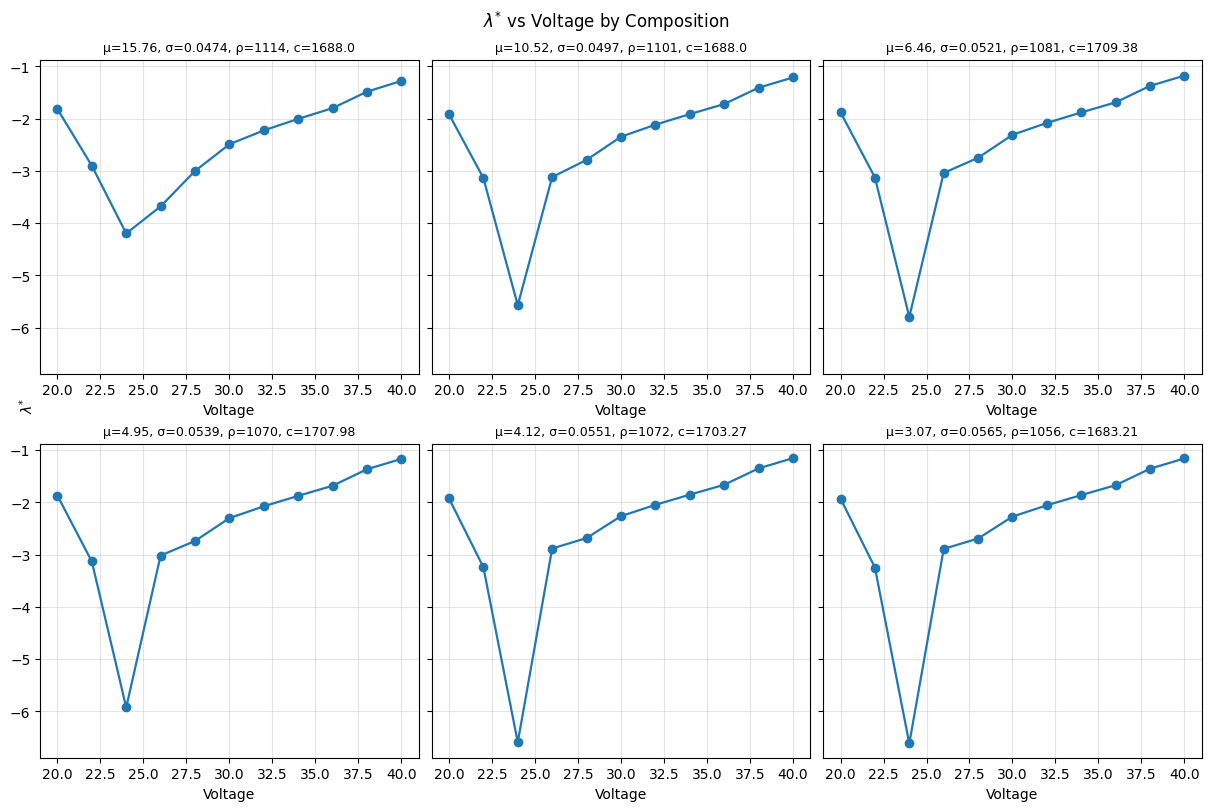

In [13]:
import io, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 1) 제공된 표 데이터를 그대로 사용 (Dummy data 아님)
# ─────────────────────────────────────────────────────────────
data_str = """mu	sigma	rho	c	t	V_name
15.76	0.0474	1114	1688	118	v20
15.76	0.0474	1114	1688	121	v22
15.76	0.0474	1114	1688	122	v24
15.76	0.0474	1114	1688	130	v26
15.76	0.0474	1114	1688	123	v28
15.76	0.0474	1114	1688	122	v30
15.76	0.0474	1114	1688	123	v32
15.76	0.0474	1114	1688	123	v34
15.76	0.0474	1114	1688	122	v36
15.76	0.0474	1114	1688	120	v38
15.76	0.0474	1114	1688	128	v40
10.52	0.0497	1101	1688	118	v20
10.52	0.0497	1101	1688	121	v22
10.52	0.0497	1101	1688	122	v24
10.52	0.0497	1101	1688	130	v26
10.52	0.0497	1101	1688	123	v28
10.52	0.0497	1101	1688	122	v30
10.52	0.0497	1101	1688	123	v32
10.52	0.0497	1101	1688	123	v34
10.52	0.0497	1101	1688	122	v36
10.52	0.0497	1101	1688	120	v38
10.52	0.0497	1101	1688	128	v40
6.46	0.0521	1081	1709.38	118	v20
6.46	0.0521	1081	1709.38	121	v22
6.46	0.0521	1081	1709.38	122	v24
6.46	0.0521	1081	1709.38	130	v26
6.46	0.0521	1081	1709.38	123	v28
6.46	0.0521	1081	1709.38	122	v30
6.46	0.0521	1081	1709.38	123	v32
6.46	0.0521	1081	1709.38	123	v34
6.46	0.0521	1081	1709.38	122	v36
6.46	0.0521	1081	1709.38	120	v38
6.46	0.0521	1081	1709.38	128	v40
4.95	0.0539	1070	1707.98	118	v20
4.95	0.0539	1070	1707.98	121	v22
4.95	0.0539	1070	1707.98	122	v24
4.95	0.0539	1070	1707.98	130	v26
4.95	0.0539	1070	1707.98	123	v28
4.95	0.0539	1070	1707.98	122	v30
4.95	0.0539	1070	1707.98	123	v32
4.95	0.0539	1070	1707.98	123	v34
4.95	0.0539	1070	1707.98	122	v36
4.95	0.0539	1070	1707.98	120	v38
4.95	0.0539	1070	1707.98	128	v40
4.12	0.0551	1072	1703.27	118	v20
4.12	0.0551	1072	1703.27	121	v22
4.12	0.0551	1072	1703.27	122	v24
4.12	0.0551	1072	1703.27	130	v26
4.12	0.0551	1072	1703.27	123	v28
4.12	0.0551	1072	1703.27	122	v30
4.12	0.0551	1072	1703.27	123	v32
4.12	0.0551	1072	1703.27	123	v34
4.12	0.0551	1072	1703.27	122	v36
4.12	0.0551	1072	1703.27	120	v38
4.12	0.0551	1072	1703.27	128	v40
3.07	0.0565	1056	1683.21	118	v20
3.07	0.0565	1056	1683.21	121	v22
3.07	0.0565	1056	1683.21	122	v24
3.07	0.0565	1056	1683.21	130	v26
3.07	0.0565	1056	1683.21	123	v28
3.07	0.0565	1056	1683.21	122	v30
3.07	0.0565	1056	1683.21	123	v32
3.07	0.0565	1056	1683.21	123	v34
3.07	0.0565	1056	1683.21	122	v36
3.07	0.0565	1056	1683.21	120	v38
3.07	0.0565	1056	1683.21	128	v40
"""
df = pd.read_csv(io.StringIO(data_str), sep=r"\s+")

# 전압 숫자 추출
def parse_voltage(vname: str) -> int:
    m = re.search(r"(\d+)", str(vname))
    if not m:
        raise ValueError(f"Invalid V_name: {vname}")
    return int(m.group(1))

df["Voltage"] = df["V_name"].map(parse_voltage)

# 조성별 그룹핑
group_keys = ["mu", "sigma", "rho", "c"]
groups = list(df.groupby(group_keys, sort=False))

# ─────────────────────────────────────────────────────────────
# 2) 플롯: 2×3 서브플롯, y축 라벨은 fig.text 로 중앙 배치
#    bo_objective, model, WAVE_DB, DEVICE 는 사용자 환경에 정의되어 있어야 함
# ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True, constrained_layout=True)
axes = axes.ravel()

# 시각화에 사용된 데이터 누적용 리스트
records = []

for ax, (comp, g) in zip(axes, groups):
    g_sorted = g.sort_values("Voltage")

    # rows: (mu, sigma, rho, c, t, V_name)
    rows = [(float(comp[0]), float(comp[1]), float(comp[2]), float(comp[3]),
             float(t), str(vn)) for t, vn in zip(g_sorted["t"], g_sorted["V_name"])]

    # λ* 계산
    lam_list = [bo_objective(cand, model, WAVE_DB, DEVICE) for cand in rows]
    volts    = g_sorted["Voltage"].to_numpy()

    # 플롯
    ax.plot(volts, lam_list, marker="o", linewidth=1.6)
    ax.set_xlabel("Voltage")
    ax.grid(True, alpha=0.35)
    ax.set_title(f"μ={comp[0]}, σ={comp[1]}, ρ={comp[2]}, c={comp[3]}", fontsize=9)

    # 콘솔로 각 조성의 최소값 보고
    idx_min = int(np.argmin(lam_list))
    print(f"[Comp μ={comp[0]}, σ={comp[1]}, ρ={comp[2]}, c={comp[3]}] "
          f"min λ*={lam_list[idx_min]:+.3e} @ V={volts[idx_min]} (wave={rows[idx_min][-1]})")

    # CSV 저장용 레코드 누적
    for lam, vol, row in zip(lam_list, volts, rows):
        records.append({
            "mu": comp[0], "sigma": comp[1], "rho": comp[2], "c": comp[3],
            "t": row[4], "V_name": row[5], "Voltage": int(vol),
            "lambda_star": float(lam)
        })

# 공통 Y라벨(요청: fig.text 사용)
fig.text(0.01, 0.5, r"$\lambda^{*}$", va="center", rotation=90)
fig.suptitle(r"$\lambda^{*}$ vs Voltage by Composition", fontsize=12)

# ─────────────────────────────────────────────────────────────
# 3) 시각화에 사용된 데이터 CSV로 저장
#    - 전체 곡선 데이터: lambda_vs_voltage_by_composition.csv
#    - 조성별 최소값 요약: lambda_min_by_composition.csv
# ─────────────────────────────────────────────────────────────
out_dir = os.path.join(os.getcwd(), "export_lambda")
os.makedirs(out_dir, exist_ok=True)

df_plot = pd.DataFrame.from_records(records)
df_plot = df_plot.sort_values(["mu", "sigma", "rho", "c", "Voltage"]).reset_index(drop=True)
df_plot.to_csv(os.path.join(out_dir, "lambda_vs_voltage_by_composition.csv"),
               index=False, encoding="utf-8-sig")

idxmin = df_plot.groupby(["mu", "sigma", "rho", "c"])["lambda_star"].idxmin()
df_min = df_plot.loc[idxmin].copy().sort_values(["mu", "sigma", "rho", "c"]).reset_index(drop=True)
df_min = df_min.rename(columns={"Voltage": "min_voltage", "lambda_star": "min_lambda_star"})
df_min.to_csv(os.path.join(out_dir, "lambda_min_by_composition.csv"),
              index=False, encoding="utf-8-sig")

plt.show()


In [20]:
true_lambda = np.array([bo_objective(r, model, WAVE_DB, DEVICE) for r in rows])

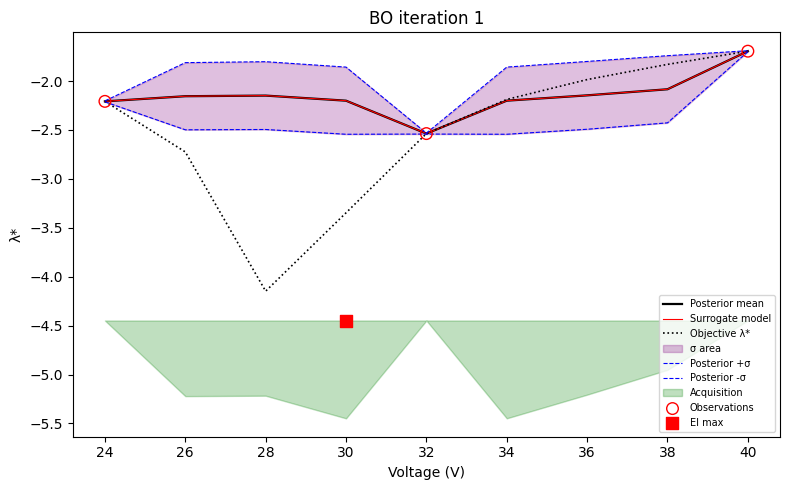

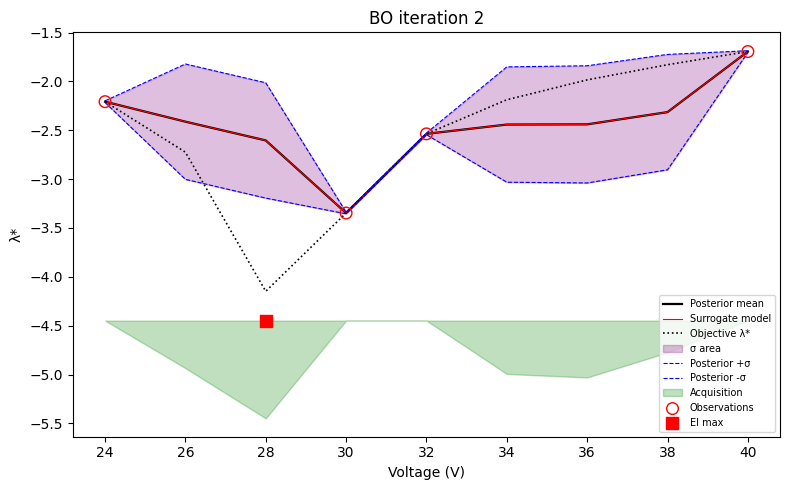

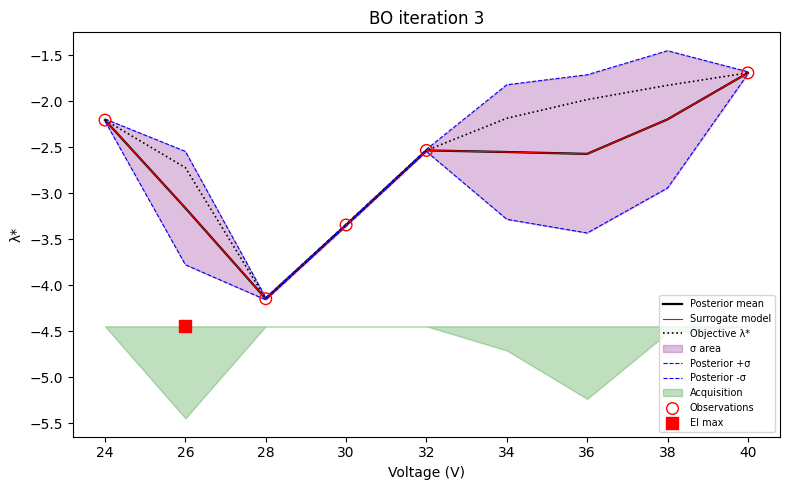

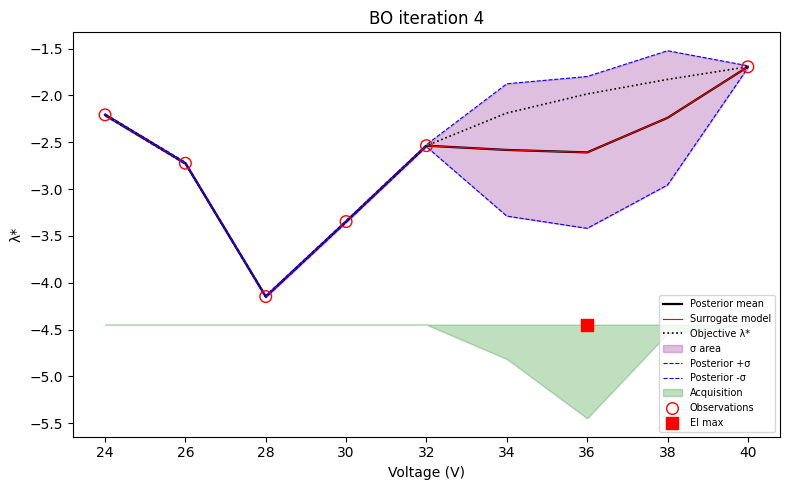

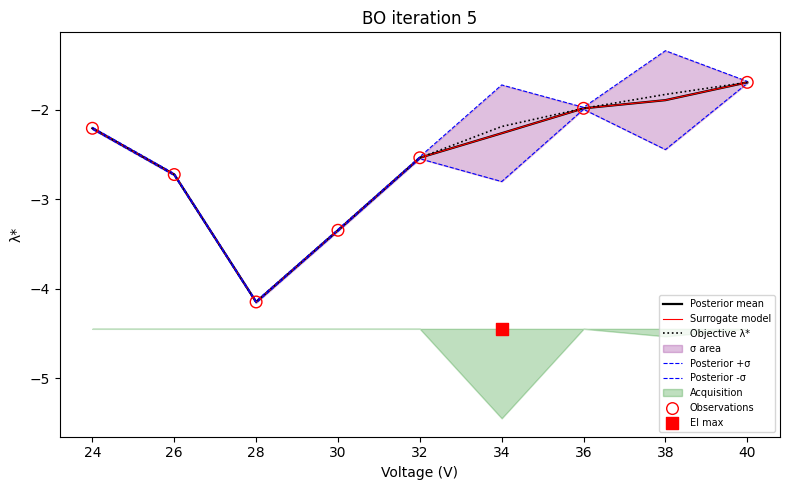

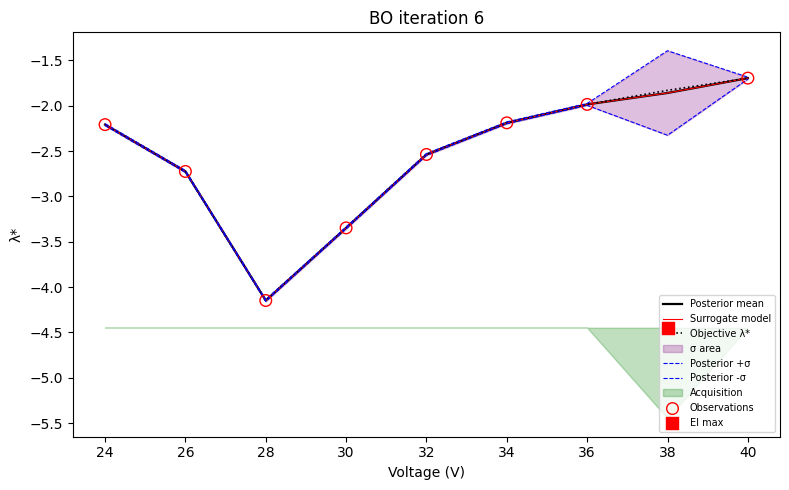

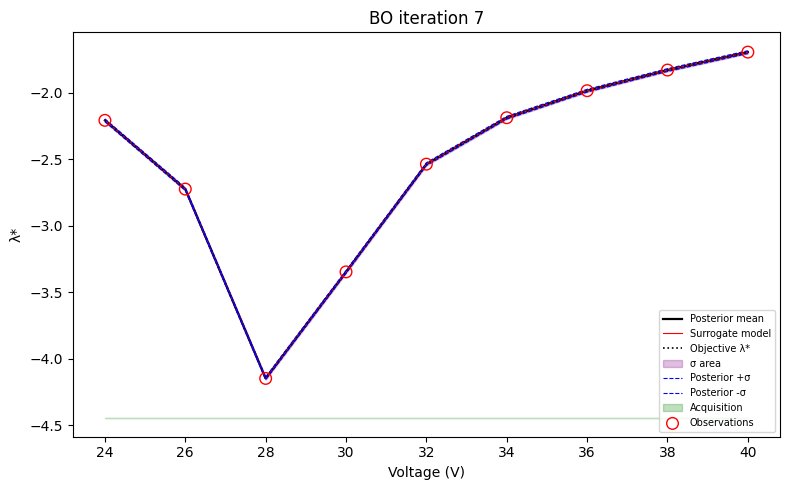

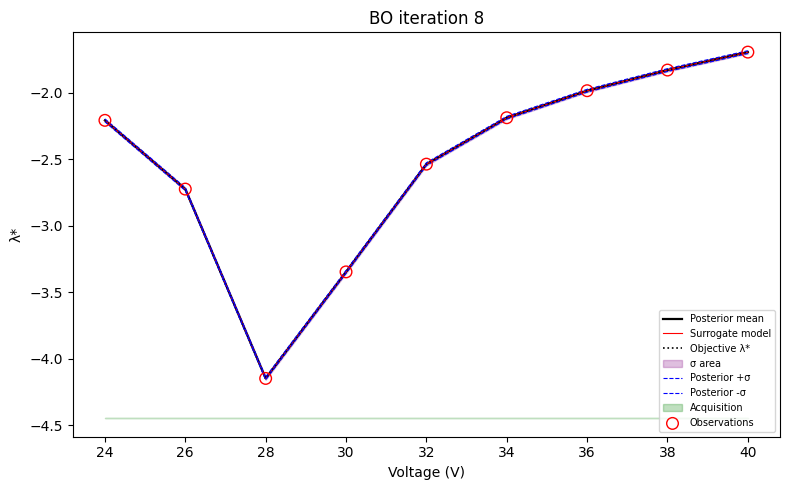

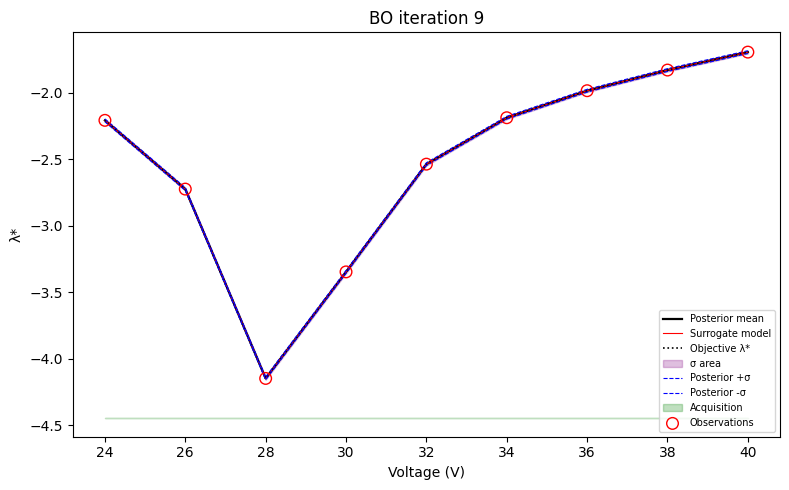

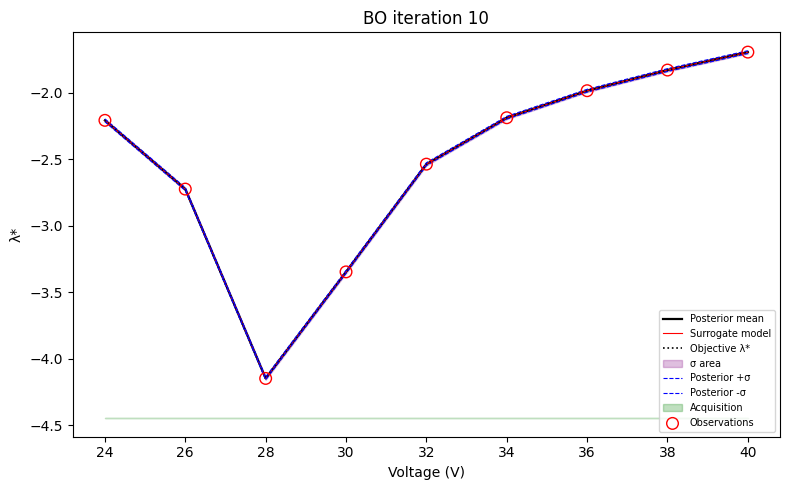

In [21]:
import re, numpy as np, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from scipy.stats import norm        # EI 계산용 CDF/PDF

# ============================================================
# 0. 데이터 준비  ─ rows : ( … , wave_id )
# ============================================================
rows = [
    (15.76,0.0474,1114,1679.5,120,"v24"),
    (15.76,0.0474,1114,1679.5,121,"v26"),
    (15.76,0.0474,1114,1679.5,122,"v28"),
    (15.76,0.0474,1114,1679.5,123,"v30"),
    (15.76,0.0474,1114,1679.5,124,"v32"),
    (15.76,0.0474,1114,1679.5,125,"v34"),
    (15.76,0.0474,1114,1679.5,126,"v36"),
    (15.76,0.0474,1114,1679.5,127,"v38"),
    (15.76,0.0474,1114,1679.5,128,"v40"),
]

# --- 전압[V] 추출 → GP 입력 X --------------------------------
voltage_grid = np.array([int(re.sub(r"\D","", r[5])) for r in rows],  ### NEW ###
                        dtype=float).reshape(-1,1)                   # (9,1)

# true_lambda : 각 행에 대한 λ* (이미 계산해 둔다고 가정)
# e.g. true_lambda = np.array([...])  # shape (9,)

# ============================================================
# 1. GP 커널
# ============================================================
kernel = (ConstantKernel(1.0,(1e-2,1e2))
          * Matern(length_scale=1.0,nu=2.5)
          + WhiteKernel(noise_level=1e-4))

# ============================================================
# 2. 초기 관측 – 전압 24 V, 32 V, 40 V  (index 0,4,8)
# ============================================================
init_idx = [0,4,8]
obs_mask = np.zeros(len(rows),bool)
obs_mask[init_idx] = True

max_iter = 10
for it in range(max_iter):
    # --------------------------------------------------------
    # (1) GP 학습
    # --------------------------------------------------------
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(voltage_grid[obs_mask],          # X_obs : (n_obs,1)   
           true_lambda[obs_mask])           # y_obs

    mu, std = gp.predict(voltage_grid, return_std=True)  

    # --------------------------------------------------------
    # (2) Expected Improvement
    # --------------------------------------------------------
    f_best = true_lambda[obs_mask].min()
    sigma  = np.maximum(std, 1e-9)
    z = (f_best - mu)/sigma
    ei = (f_best - mu)*norm.cdf(z) + sigma*norm.pdf(z)
    ei[obs_mask] = 0.0
    ei_norm = ei / (ei.max() + 1e-12)

    # --------------------------------------------------------
    # (3) 시각화
    # --------------------------------------------------------
    plt.figure(figsize=(8,5))

    plt.plot(voltage_grid, mu, 'k-', lw=1.6, label='Posterior mean')
    plt.plot(voltage_grid, mu, 'r-', lw=0.8, label='Surrogate model')
    plt.plot(voltage_grid, true_lambda, 'k:', lw=1.2, label='Objective λ*')

    plt.fill_between(voltage_grid.flatten(), mu-std, mu+std,
                     color='purple', alpha=0.25, label='σ area')
    plt.plot(voltage_grid, mu+std, 'b--', lw=0.8, label='Posterior +σ')
    plt.plot(voltage_grid, mu-std, 'b--', lw=0.8, label='Posterior -σ')

    ei_offset = true_lambda.min() - 0.3
    plt.fill_between(voltage_grid.flatten(), ei_offset,
                     ei_offset - ei_norm,
                     color='green', alpha=0.25, label='Acquisition')

    plt.scatter(voltage_grid[obs_mask], true_lambda[obs_mask],
                facecolors='none', edgecolors='red', s=70,
                zorder=5, label='Observations')

    if (~obs_mask).any():
        next_idx = int(np.argmax(ei))
        plt.scatter(voltage_grid[next_idx], ei_offset, marker='s',
                    color='red', s=80, zorder=6, label='EI max')

    plt.xlabel('Voltage (V)')               ### NEW ###
    plt.ylabel('λ*')
    plt.title(f'BO iteration {it+1}')
    plt.legend(loc='lower right', fontsize=7)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------
    # (4) 관측 집합 업데이트
    # --------------------------------------------------------
    if (~obs_mask).any():
        obs_mask[next_idx] = True


---


[01] ls=[0.6931472 0.6931472 0.6931472 0.6931472 0.6931472 0.6931472], out=6.331e-02, noise=6.342e-02
[02] ls=[5.106795  5.055311  5.073879  2.1241665 5.1058316 5.106177 ], out=7.563e-02, noise=4.469e-02
[03] ls=[6.4060946 6.3126025 6.2938933 5.34624   5.9109383 1.0371886], out=2.508e-01, noise=7.189e-03
[04] ls=[ 7.705173   7.5412226 15.3813715 23.81373    6.688175   1.2871795], out=4.510e-01, noise=1.376e-03
[05] ls=[ 7.3339276  7.1639366 11.10873   25.700308   7.384197   0.9731529], out=3.781e-01, noise=3.562e-04
[06] ls=[ 7.066886   6.939519  11.582636  12.112617   8.000826   1.0740542], out=3.419e-01, noise=1.517e-04
[07] ls=[7.0083303 6.855377  9.196028  6.2546325 6.7049837 1.1652101], out=3.645e-01, noise=1.004e-04
[08] ls=[6.327155   6.165435   6.2568307  0.33765414 5.839938   1.2075921 ], out=5.416e-01, noise=1.000e-04
[09] ls=[6.05015   5.882131  6.0274014 0.4001181 5.56985   1.1153865], out=4.867e-01, noise=1.000e-04
[10] ls=[5.99018   5.8157263 5.9741445 0.7562751 5.574166 

c:\Users\HMCL-252\anaconda3\envs\myenv\lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


[14] ls=[6.4978957 6.2481294 7.454614  0.8558433 6.027648  1.0951257], out=6.024e-01, noise=1.000e-04
[15] ls=[6.542782  6.279988  5.8152437 0.7009879 5.808162  1.1614897], out=8.461e-01, noise=1.000e-04
[16] ls=[5.347071   5.1283545  5.2033014  0.17727019 4.8659687  1.356221  ], out=7.929e-01, noise=1.000e-04
[17] ls=[6.3534193 6.0810485 4.4821115 1.2740996 5.3462796 1.073415 ], out=7.879e-01, noise=1.000e-04
[18] ls=[6.419017  6.1309824 5.648014  0.503583  5.6935735 1.1792214], out=7.889e-01, noise=1.000e-04
[19] ls=[6.3768516  6.069378   4.7241864  0.98270667 5.3766303  1.0886059 ], out=7.410e-01, noise=1.000e-04
[20] ls=[6.5174203 6.180555  6.24225   0.5405118 5.905664  1.1843544], out=7.418e-01, noise=1.000e-04


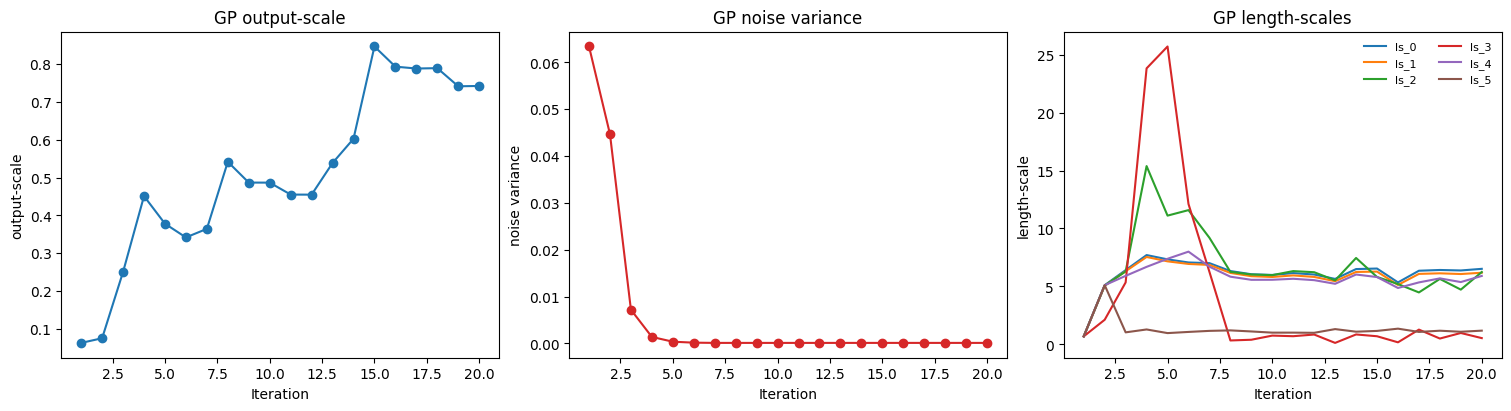

In [23]:
# ======================================================================
# 0) 라이브러리 · 환경 ----------------------------------------------------
# ======================================================================
import math, os, numpy as np, torch, gpytorch, pandas as pd, matplotlib.pyplot as plt
from gpytorch.mlls import ExactMarginalLogLikelihood
from typing import Dict, List, Tuple

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)
torch.manual_seed(0); np.random.seed(0)

# ======================================================================
# 1) DeepONet, WAVE_DB, model  ------------------------------------------
#  - DeepONet는 반드시 스칼라 5차원(branch1 입력=5) 버전이어야 함
#  - WAVE_DB: {'v24': np.ndarray(300,), ...}가 준비되어 있어야 함
# ======================================================================

# ──────────────────────────────────────────────────────────────────────
# 1-A) bo_objective  (DeepONet → λ*)
#    변경: p 제거 → candidate = (mu, sigma, rho, c_val, t_us, wid)
# ──────────────────────────────────────────────────────────────────────
def bo_objective(candidate,
                 model,
                 wave_db,
                 device: torch.device = torch.device("cpu")) -> float:
    """Return λ* (ln(r_fin / r_pinch)); more-negative ⇒ faster decay."""
    mu, sigma, rho, c_val, t_us, wid = candidate  # ★ p 제거

    # waveform
    wave = wave_db[wid]                                # KeyError → 전파
    if wave.shape[0] != 300:
        raise ValueError("waveform length must be exactly 300")

    # x1: (1,5), x2: (1,300)
    x1 = torch.tensor([mu, sigma, rho, c_val, t_us],
                      dtype=torch.float32, device=device).unsqueeze(0)   # ★ 6→5
    x2 = torch.from_numpy(wave.astype(np.float32)).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        q_hat = model(x1, x2).squeeze(0)               # (300,)

    idx_pinch = int(t_us) - 1
    if not 0 <= idx_pinch < 300:
        raise ValueError("t_us must be in [1, 300]")
    r_pinch = q_hat[idx_pinch].abs() + 1e-12
    r_fin   = q_hat[-1].abs()        + 1e-12
    return torch.log(r_fin / r_pinch).item()

# ======================================================================
# 2) wave_id ↔ 정수 매핑 -------------------------------------------------
# ======================================================================
wave_ids = sorted(WAVE_DB.keys())          # e.g. ['v1', 'v2', ...]
id2idx   = {wid: i for i, wid in enumerate(wave_ids)}
idx2id   = {i: wid for wid, i in id2idx.items()}

def enc(mu, sigma, rho, c, t_us, wid):
    """Encode candidate → (6,) tensor [mu, sigma, rho, c, t_us, wid_idx]."""
    return torch.tensor([mu, sigma, rho, c, t_us, float(id2idx[wid])],
                        dtype=torch.float32)                       # ★ p 제거, 길이 6

def dec(x: torch.Tensor):
    """Decode (6,) tensor back to tuple with wave_id string."""
    mu, sigma, rho, c, t_us, idx_f = x.tolist()
    return (mu, sigma, rho, c, t_us, idx2id[int(idx_f)])          # ★ 6개 체계

# ======================================================================
# 3) GP 모델 정의 --------------------------------------------------------
# ======================================================================
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module  = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1])
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x= self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def extract_hp(model: ExactGP) -> Dict[str, np.ndarray]:
    base = model.covar_module.base_kernel
    return {
        "lengthscale": base.lengthscale.detach().cpu().numpy().ravel(),
        "outputscale": model.covar_module.outputscale.detach().cpu().item(),
        "noise":      model.likelihood.noise.detach().cpu().item()
    }

# ======================================================================
# 4) Expected Improvement ----------------------------------------------
# ======================================================================
import torch.distributions as D
def expected_improvement(mu, sigma, f_best, xi=0.0):
    sigma = sigma.clamp_min(1e-9)
    z     = (f_best - mu - xi) / sigma            # minimization
    std   = D.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return (f_best - mu - xi)*std.cdf(z) + sigma*torch.exp(std.log_prob(z))

# ======================================================================
# 5) Bayesian-Optimisation 루프 -----------------------------------------
# ======================================================================
def bayes_optimize(train_x, train_y, cand_pool,
                   wave_db, deepONet,
                   n_iter=15, lr=0.1, opt_steps=200, batch=128):

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(DEVICE)
    hp_log: List[Dict] = []

    for it in range(1, n_iter+1):
        # --- GP 학습 ---------------------------------------------------
        gp = ExactGP(train_x, train_y, likelihood).to(DEVICE)
        gp.train(); likelihood.train()
        mll   = ExactMarginalLogLikelihood(likelihood, gp)
        optim = torch.optim.Adam(gp.parameters(), lr=lr)
        for _ in range(opt_steps):
            optim.zero_grad()
            loss = -mll(gp(train_x), train_y)
            loss.backward(); optim.step()
        gp.eval(); likelihood.eval()

        # --- 하이퍼 기록 -----------------------------------------------
        hp = extract_hp(gp); hp["iter"] = it; hp_log.append(hp)
        print(f"[{it:02d}] ls={hp['lengthscale']}, "
              f"out={hp['outputscale']:.3e}, noise={hp['noise']:.3e}")

        # --- EI 최대 후보 선택 -----------------------------------------
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            mu_all, sig_all = [], []
            for j in range(0, cand_pool.shape[0], batch):
                xb = cand_pool[j:j+batch].to(DEVICE)
                pred = likelihood(gp(xb))
                mu_all.append(pred.mean); sig_all.append(pred.stddev)
            mu, sig = torch.cat(mu_all), torch.cat(sig_all)

        ei  = expected_improvement(mu, sig, train_y.min().item())
        idx = torch.argmax(ei).item()
        x_n = cand_pool[idx:idx+1]

        # --- DeepONet 평가 --------------------------------------------
        y_val = bo_objective(dec(x_n[0]), model=deepONet,
                             wave_db=wave_db, device=DEVICE)
        y_n   = torch.tensor([y_val], dtype=torch.float32, device=DEVICE)

        train_x = torch.cat([train_x, x_n.to(DEVICE)], 0)
        train_y = torch.cat([train_y, y_n], 0)

    return train_x, train_y, hp_log

# ======================================================================
# 6) 초기 데이터 ---------------------------------------------------------
#    변경: p 제거 → 각 튜플은 (mu, sigma, rho, c, t_us, wid)
# ======================================================================
init_rows = [
    (15.76, 0.0474, 1114, 1679.5, 120, "v24"),
    (15.50, 0.0550, 1120, 1650.0, 125, "v26"),
    (16.00, 0.0400, 1100, 1700.0, 115, "v28"),
]
train_x0 = torch.stack([enc(*r) for r in init_rows]).to(DEVICE)      # (N0, 6)
train_y0 = torch.tensor(
    [bo_objective(r, model=model, wave_db=WAVE_DB, device=DEVICE)
     for r in init_rows],
    dtype=torch.float32, device=DEVICE)                               # (N0,)

# ======================================================================
# 7) 탐색 풀 샘플 (예시 200개) ------------------------------------------
#    변경: enc(mu, sigma, rho, c, t_us, wid)  ← p 제거
# ======================================================================
rng = np.random.default_rng(0)
cand_pool = []
for _ in range(200):
    mu, sigma = rng.uniform(15, 17), rng.uniform(0.03, 0.06)
    rho, c    = rng.uniform(1090, 1130), rng.uniform(1550, 1750)
    t_us      = int(rng.integers(110, 130))          # 보통 정수 시간 인덱스
    wid       = rng.choice(wave_ids)
    cand_pool.append(enc(mu, sigma, rho, c, t_us, wid))              # ★ p 제거
cand_pool = torch.stack(cand_pool)                                   # (200, 6)

# ======================================================================
# 8) BO 실행 ------------------------------------------------------------
# ======================================================================
_, _, hp_log = bayes_optimize(train_x0, train_y0, cand_pool,
                              WAVE_DB, model, n_iter=20)

# ======================================================================
# 9) 하이퍼파라미터 시각화 ---------------------------------------------
# ======================================================================
hp_df   = pd.DataFrame(hp_log)
len_dim = hp_df["lengthscale"][0].size
ls_cols = [f"ls_{i}" for i in range(len_dim)]
hp_df[ls_cols] = pd.DataFrame(hp_df["lengthscale"].tolist(), index=hp_df.index)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# (a) output-scale
axes[0].plot(hp_df["iter"], hp_df["outputscale"], marker='o')
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("output-scale")
axes[0].set_title("GP output-scale")

# (b) noise
axes[1].plot(hp_df["iter"], hp_df["noise"], marker='o', color='tab:red')
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("noise variance")
axes[1].set_title("GP noise variance")

# (c) length-scales (ARD)
for i, col in enumerate(ls_cols):
    axes[2].plot(hp_df["iter"], hp_df[col], label=col)
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("length-scale")
axes[2].set_title("GP length-scales")
axes[2].legend(fontsize=8, ncol=2, frameon=False)
plt.show()


In [24]:
# ── CSV 저장 ───────────────────────────────────────────────────
hp_df[['iter', 'outputscale']].to_csv('gp_outputscale.csv', index=False)

hp_df[['iter', 'noise']].to_csv('gp_noise.csv', index=False)

hp_df[['iter'] + ls_cols].to_csv('gp_lengthscales.csv', index=False)
